# 1️⃣ Environment setup & imports


In [ ]:
# !pip install -q torch torchvision tqdm matplotlib


!pip install geomloss --no-deps

  Preparing metadata (setup.py) ... done
  Created wheel for geomloss: filename=geomloss-0.2.6-py3-none-any.whl size=32247 sha256=e8e72b8f0736c862921140d99517cacd3642a561cbc3382a5767e5218a09870e
  Stored in directory: /root/.cache/pip/wheels/f5/cf/07/9d1d883feac2951b968fed8ef676842dc90b9860ea49a4dcac
Successfully built geomloss


In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from torch.distributions import Normal

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from geomloss import SamplesLoss

from itertools import cycle

# 2️⃣ Device

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cuda


# 3️⃣ Dataset choice: 'MNIST' or 'CIFAR10'

In [ ]:
DATASET = "MNIST"  # change to "CIFAR10" as needed

# 4️⃣ Transforms & DataLoaders

In [ ]:
if DATASET == "MNIST":
    n_channels = 1
    img_size   = 28
    transform = transforms.ToTensor()   # no Normalize
    train_ds = datasets.MNIST(
        root="data", train=True,  download=True, transform=transform
    )
    test_ds  = datasets.MNIST(
        root="data", train=False, download=True, transform=transform
    )

elif DATASET == "CIFAR10":
    n_channels = 3
    img_size   = 32
    transform = transforms.ToTensor()   # no Normalize
    train_ds = datasets.CIFAR10(
        root="data", train=True,  download=True, transform=transform
    )
    test_ds  = datasets.CIFAR10(
        root="data", train=False, download=True, transform=transform
    )

else:
    raise ValueError("DATASET must be 'MNIST' or 'CIFAR10'")


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]


In [ ]:
# Split a small validation set from the training set (e.g. 10%)
val_size = int(0.1 * len(train_ds))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

# DataLoader parameters
BATCH_SIZE = 128
NUM_WORKERS = 2  # increase if your Colab runtime supports it

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Loaded {DATASET}:")
print(f"  • train:      {len(train_ds)} samples")
print(f"  • validation: {len(val_ds)} samples")
print(f"  • test:       {len(test_ds)} samples")
print(f"Batch size: {BATCH_SIZE}, Channels: {n_channels}, Image size: {img_size}×{img_size}")

Loaded MNIST:
  • train:      54000 samples
  • validation: 6000 samples
  • test:       10000 samples
Batch size: 128, Channels: 1, Image size: 28×28


# 5️⃣ Model Implementations

In [ ]:
# ──────────── pick your data here ────────────
DATASET = "MNIST"   # "MNIST" or "CIFAR10"
if DATASET == "MNIST":
    C, H = 1, 28
elif DATASET == "CIFAR10":
    C, H = 3, 32
else:
    raise ValueError(f"Unsupported DATASET: {DATASET}")
# ───────────────────────────────────────────────

In [ ]:
# Shared blocks
class Encoder(nn.Module):
    def __init__(self, z_dim=20, bn=False):
        super().__init__()
        flat = 64 * (H//4) * (H//4)
        self.conv = nn.Sequential(
            nn.Conv2d(C,  32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
        )
        self.bn    = nn.BatchNorm1d(flat) if bn else nn.Identity()
        self.fc_mu = nn.Linear(flat, z_dim)
        self.fc_lv = nn.Linear(flat, z_dim)

    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        h = self.bn(h)
        return self.fc_mu(h), self.fc_lv(h)


class Decoder(nn.Module):
    def __init__(self, z_dim=20):
        super().__init__()
        self.fc = nn.Linear(z_dim, 64 * (H//4) * (H//4))
        self.deconv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32,  C, 4, 2, 1), nn.Sigmoid(),
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0), 64, H//4, H//4)
        return self.deconv(h)


def reparam(mu, lv):
    std = (0.5*lv).exp()
    return mu + std * torch.randn_like(std)


In [ ]:
class BaseVAE(nn.Module):
    def __init__(self, z_dim=20, beta=1.0, bn=False):
        super().__init__()
        self.enc = Encoder(z_dim=z_dim, bn=bn)
        self.dec = Decoder(z_dim=z_dim)
        self.beta = beta
    def forward(self, x):
        mu, lv = self.enc(x)
        z = reparam(mu, lv)
        return self.dec(z), mu, lv
    def loss(self, x, recon, mu, lv, epoch=None):
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        return bce + self.beta * kld, {'bce': bce.item(), 'kld': kld.item(), 'extra': 0.0}

# vanilla ELBO‐VAE (α=1.0, i.e. β=1.0)
class ELBOVAE(BaseVAE):
    def __init__(self, z_dim=20, bn=False):
        super().__init__(z_dim=z_dim, beta=1.0, bn=bn)
    # inherits forward & loss exactly (BCE + 1·KLD)

# “Reconstruction‐only” auto‐encoder (no KLD at all)
class ReconAE(BaseVAE):
    def __init__(self, z_dim=20, bn=False):
        super().__init__(z_dim=z_dim, beta=0.0, bn=bn)
    def loss(self, x, recon, mu, lv, epoch=None):
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        return bce, {'bce': bce.item(), 'kld': 0.0, 'extra': 0.0}

# Free‐bits VAE (do not penalize any KL‐dim below `fb` nats)
class FreeBitsVAE(BaseVAE):
    def __init__(self, z_dim=20, beta=1.0, free_bits=0.1, bn=False):
        super().__init__(z_dim=z_dim, beta=beta, bn=bn)
        self.free_bits = free_bits

    def loss(self, x, recon, mu, lv, epoch=None):
        B = x.size(0)
        # reconstruction term
        bce = F.binary_cross_entropy(recon, x, reduction='sum')

        # compute per‐dimension KL z‐dim→shape [B, z_dim]
        kld_mat = -0.5 * (1 + lv - mu.pow(2) - lv.exp())  # [B, z_dim]
        # average over batch → [z_dim]
        kld_dim = kld_mat.mean(0)
        # apply free‐bits threshold
        kld_dim_clamped = torch.clamp(kld_dim, min=self.free_bits)
        # total KL = sum dims * batch_size
        kld_fb = kld_dim_clamped.sum() * B

        total = bce + self.beta * kld_fb
        return total, {
            'bce': bce.item(),
            'kld': kld_fb.item(),
            'free_bits': self.free_bits
        }


# β-VAE (beta parameter)
class BetaVAE(BaseVAE):
    def __init__(self, z_dim=20, beta=4.0, bn=False):
        super().__init__(z_dim=z_dim, beta=beta, bn=bn)

# BN‑VAE (batchnorm in encoder)
class BNVAE(BaseVAE):
    def __init__(self, z_dim=20):
        super().__init__(z_dim=z_dim, beta=1.0, bn=True)


In [ ]:
# AAE (Adversarial Autoencoder)
class Discriminator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim,128), nn.ReLU(),
            nn.Linear(128,1)
        )
    def forward(self, z): return self.net(z)

class AAE(nn.Module):
    def __init__(self, z_dim=20):
        super().__init__()
        self.enc = Encoder(z_dim=z_dim)
        self.dec = Decoder(z_dim=z_dim)
        self.disc = Discriminator(z_dim).to(DEVICE)
        self.opt_d = optim.Adam(self.disc.parameters(), lr=1e-4)
    def forward(self, x):
        mu, lv = self.enc(x)
        z = reparam(mu, lv)
        return self.dec(z), mu, lv, z
    def loss(self, x, recon, mu, lv, z, epoch=None):
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        # train discriminator
        real = torch.randn_like(z)
        d_real = self.disc(real)
        d_fake = self.disc(z.detach())
        ld = F.binary_cross_entropy_with_logits(d_real, torch.ones_like(d_real)) + \
             F.binary_cross_entropy_with_logits(d_fake, torch.zeros_like(d_fake))
        self.opt_d.zero_grad(); ld.backward(); self.opt_d.step()
        # generator loss
        g_loss = F.binary_cross_entropy_with_logits(self.disc(z), torch.ones_like(d_fake))
        return bce + g_loss, {'bce': bce.item(), 'kld': 0.0, 'extra': g_loss.item()}

In [ ]:
# InfoVAE-Stein (kernelized Stein discrepancy)
def ksd_rbf(z, sigma=1.0):
    """
    Kernelized Stein discrepancy for q(z)=Empirical vs. p(z)=N(0,I)
    Using the RBF kernel k(z,z')=exp(-||z-z'||^2/(2σ^2)).
    """
    B, D = z.size()
    # pairwise differences
    z_i = z.unsqueeze(1)           # [B,1,D]
    z_j = z.unsqueeze(0)           # [1,B,D]
    diff = z_i - z_j               # [B,B,D]

    # kernel matrix
    K = torch.exp(-(diff.pow(2).sum(-1)) / (2 * sigma**2))  # [B,B]

    # score_p = ∇_z log p(z) with p=N(0,I) → -z
    s_i = -z_i                     # [B,1,D]
    s_j = -z_j                     # [1,B,D]

    # term1: s_iᵀ s_j * K  → shape [B,B]
    t1 = (s_i * s_j).sum(-1) * K

    # term2: s_iᵀ ∇_{z_j} k = s_iᵀ [ (z_i-z_j)/σ² * K ]  → shape [B,B]
    grad_j_K = diff / (sigma**2) * K.unsqueeze(-1)  # [B,B,D]
    t2       = (s_i * grad_j_K).sum(-1)

    # term3: s_jᵀ ∇_{z_i} k = s_jᵀ [ -(z_i-z_j)/σ² * K ]  → shape [B,B]
    grad_i_K = -grad_j_K
    t3       = (s_j * grad_i_K).sum(-1)

    U = t1 + t2 + t3              # [B,B]
    return U.mean()               # scalar

class InfoVAE_Stein(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0, sigma=1.0):
        super().__init__()
        self.enc, self.dec = Encoder(z_dim), Decoder(z_dim)
        self.alpha, self.lam, self.sigma = alpha, lam, sigma

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        B = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        stein = ksd_rbf(z, sigma=self.sigma) * B
        total = bce + (1-self.alpha)*kld + (self.alpha+self.lam-1)*stein
        return total, {'bce':bce.item(),'kld':kld.item(),'stein':stein.item()}


# InfoVAE-MMD (your original)
def mmd_rbf(q, p, sigma=1.0):
    def pd2(a,b): return torch.cdist(a,b).pow(2)
    Kqq = torch.exp(-pd2(q,q)/(2*sigma**2)).mean()
    Kpp = torch.exp(-pd2(p,p)/(2*sigma**2)).mean()
    Kqp = torch.exp(-pd2(q,p)/(2*sigma**2)).mean()
    return Kqq + Kpp - 2*Kqp

class InfoVAE_MMD(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0, sched=None, sigma=1.0):
        super().__init__()
        self.enc, self.dec = Encoder(z_dim), Decoder(z_dim)
        self.alpha, self.lam, self.sched, self.sigma = alpha, lam, sched, sigma

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        alpha, lam = (self.alpha,self.lam) if self.sched is None else self.sched(epoch)
        B   = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        mmd = mmd_rbf(z, torch.randn_like(z), sigma=self.sigma) * B
        total = bce + (1-alpha)*kld + (alpha+lam-1)*mmd
        return total, {'bce':bce.item(),'kld':kld.item(),'mmd':mmd.item(),
                       'alpha':alpha,'lam':lam}


# InfoVAE-Sinkhorn (entropic OT via geomloss)
class InfoVAE_Sinkhorn(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0, blur=0.1):
        super().__init__()
        self.enc   = Encoder(z_dim)
        self.dec   = Decoder(z_dim)
        self.blur  = blur
        # geomloss SamplesLoss("sinkhorn") computes the Sinkhorn divergence
        self.sinkhorn = SamplesLoss("sinkhorn", p=2, blur=blur)
        self.alpha, self.lam = alpha, lam

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        B   = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        # Sinkhorn divergence between q(z) and p(z)=N(0,I)
        prior = torch.randn_like(z)
        sink = self.sinkhorn(z, prior) * B
        total = bce + (1-self.alpha)*kld + (self.alpha+self.lam-1)*sink
        return total, {'bce':bce.item(),'kld':kld.item(),'sinkhorn':sink.item()}


# InfoVAE-Cramér (Energy distance)
def cramer_distance(q, p):
    """
    Cramér (a.k.a. energy) distance:
      E||q−p|| − 1/2 E||q−q'|| − 1/2 E||p−p'||
    """
    d_qp = torch.cdist(q, p, p=2).mean()
    d_qq = torch.cdist(q, q, p=2).mean()
    d_pp = torch.cdist(p, p, p=2).mean()
    return d_qp - 0.5*d_qq - 0.5*d_pp

class InfoVAE_Cramer(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0):
        super().__init__()
        self.enc, self.dec = Encoder(z_dim), Decoder(z_dim)
        self.alpha, self.lam = alpha, lam

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        B   = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())

        # energy distance vs. standard normal
        prior = torch.randn_like(z)
        crim  = cramer_distance(z, prior) * B

        total = bce + (1-self.alpha)*kld + (self.alpha+self.lam-1)*crim
        return total, {
            'bce':   bce.item(),
            'kld':   kld.item(),
            'cramer': crim.item()
        }


class InfoVAE_Chi2(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0, lr=1e-4):
        super().__init__()
        self.enc   = Encoder(z_dim)
        self.dec   = Decoder(z_dim)
        self.T_net = nn.Sequential(
            nn.Linear(z_dim, 128), nn.ReLU(),
            nn.Linear(128, 1)
        ).to(DEVICE)
        self.opt_T = optim.Adam(self.T_net.parameters(), lr=lr)
        self.alpha, self.lam = alpha, lam

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        B   = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())

        # ── 1) Update T_net *only* via detached z, so we never touch the VAE graph
        z_det     = z.detach()                      # <— detach here!
        z_prior   = torch.randn_like(z_det)
        T_q       = self.T_net(z_det)
        T_p       = self.T_net(z_prior)
        loss_T    = -(T_q.mean() - (T_p + 0.25 * T_p.pow(2)).mean())
        self.opt_T.zero_grad()
        loss_T.backward()                           # only flows into T_net
        self.opt_T.step()

        # ── 2) Compute the χ² term *without* no_grad, but it only uses bce/kld
        with torch.no_grad():
            # we keep the same formula so χ² enters as a constant
            T_q2  = self.T_net(z_det)
            T_p2  = self.T_net(z_prior)
            chi2  = (T_q2.mean() - (T_p2 + 0.25*T_p2.pow(2)).mean()) * B

        total = bce + (1-self.alpha)*kld + (self.alpha+self.lam-1)*chi2
        return total, {
            'bce':  bce.item(),
            'kld':  kld.item(),
            'chi2': chi2.item()
        }




In [ ]:
# ContrastiveAE<

def cosine_sim_matrix(z):
    zn = F.normalize(z, dim=1)
    return torch.matmul(zn, zn.t())

class ContrastiveAE(nn.Module):
    def __init__(self, z_dim=20, beta=1.0, w=10.0):
        super().__init__()
        self.enc = Encoder(z_dim)
        self.dec = Decoder(z_dim)
        self.beta, self.w = beta, w
    def forward(self, x):
        mu, lv = self.enc(x)
        z = reparam(mu, lv)
        return self.dec(z), mu, lv, z
    def nce(self, z):
        sim = cosine_sim_matrix(z)
        logits = sim / 0.1
        labels = torch.arange(z.size(0), device=z.device)
        return F.cross_entropy(logits, labels) * z.size(0)
    def loss(self, x, recon, mu, lv, z, epoch=None):
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        nce = self.nce(z)
        total = bce + self.beta*kld + self.w*nce
        return total, {'bce': bce.item(), 'kld': kld.item(), 'extra': nce.item()}

# InfoVAE MNIST Experiments

This notebook runs three categories of experiments on MNIST:
1. Hyperparameter Sensitivity & Adaptive Scheduling of α, λ  
2. Divergence Substitution  
3. General Model Comparison  

We'll log MMD, reconstruction loss, and semi-supervised classification error as functions of iterations and latent dimensionality.


# 6️⃣ Experiment 1: Hyperparameter Sensitivity & Adaptive Scheduling of α and λ (InfoVAE-MMD)


Schedules:   0%|          | 0/9 [00:00<?, ?it/s]

Fixed λ=500, α=1.0:   0%|          | 0/5000 [00:00<?, ?it/s]

Fixed λ=1000, α=1.0:   0%|          | 0/5000 [00:00<?, ?it/s]

Fixed λ=500, α=0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Fixed λ=1000, α=0.5:   0%|          | 0/5000 [00:00<?, ?it/s]

Fixed λ=500, α=0.0:   0%|          | 0/5000 [00:00<?, ?it/s]

Fixed λ=1000, α=0.0:   0%|          | 0/5000 [00:00<?, ?it/s]

Adaptive λ only:   0%|          | 0/5000 [00:00<?, ?it/s]

Adaptive α only:   0%|          | 0/5000 [00:00<?, ?it/s]

Adaptive λ and α:   0%|          | 0/5000 [00:00<?, ?it/s]

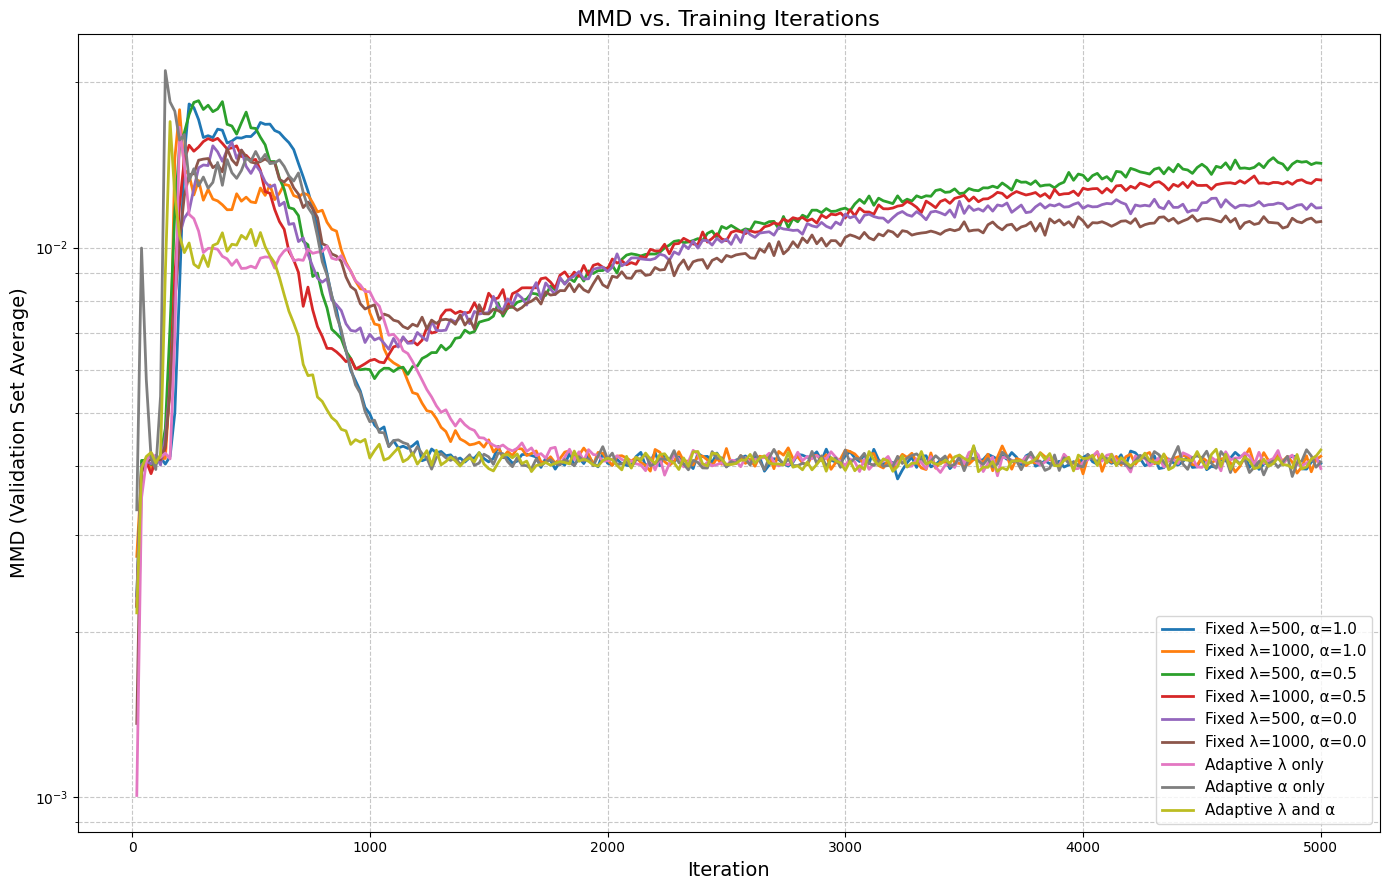

In [ ]:
# ----------------------------------------------------------------------------
# Experiment Configuration
# ----------------------------------------------------------------------------
sigma          = 1.0
val_K          = 500
val_batch_size = 256
eval_every     = 20
num_iterations = 5000

# Get fixed validation batches
val_batches = []
temp_loader = DataLoader(val_ds, batch_size=val_batch_size, shuffle=False)
for i, (x, _) in enumerate(temp_loader):
    if i >= val_K: break
    val_batches.append(x.to(DEVICE).float())

# MMD evaluation function (unbiased)
def rbf_mmd_eval(x, y, sigma):
    x = x.view(x.size(0), -1); y = y.view(y.size(0), -1)
    N, M = x.size(0), y.size(0)
    if N < 2 or M < 2: return 0.0
    xx = (x*x).sum(1, keepdim=True); yy = (y*y).sum(1, keepdim=True)
    dxx = xx - 2*(x@x.t()) + xx.t()
    dyy = yy - 2*(y@y.t()) + yy.t()
    dxy = xx - 2*(x@y.t()) + yy.t()
    Kxx = torch.exp(-dxx/(2*sigma**2)); Kyy = torch.exp(-dyy/(2*sigma**2)); Kxy = torch.exp(-dxy/(2*sigma**2))
    sum_xx = Kxx.sum() - Kxx.diagonal().sum(); sum_yy = Kyy.sum() - Kyy.diagonal().sum()
    mmd2 = sum_xx/(N*(N-1)) + sum_yy/(M*(M-1)) - 2*Kxy.mean()
    return torch.sqrt(torch.clamp(mmd2, min=0.0)).item()

# ----------------------------------------------------------------------------
# Controller‐style hyper‐parameters
# ----------------------------------------------------------------------------
TARGET_MMD     = 0.0004     # aim for the plateau of the best fixed curve (~0.004)
LAM_LR         = 5000.0    # stronger “push” on λ per unit MMD‐error
ALPHA_LR       = 0.7      # quicker α adjustments
MIN_LAMBDA     =  500.0    # stay near the sweet‐spot region
MAX_LAMBDA     = 1500.0
MIN_ALPHA      =   1.0     # keep α close to 0.5 ±0.2
MAX_ALPHA      =   3.0
INITIAL_LAMBDA = 500.0
INITIAL_ALPHA  =   1.0

# ----------------------------------------------------------------------------
# 1) Live‐adaptive λ only (α held fixed)
# ----------------------------------------------------------------------------
class LiveAdaptiveLambda:
    def __init__(self,
                 init_lambda=INITIAL_LAMBDA,
                 lr=LAM_LR,
                 target_mmd=TARGET_MMD):
        self.lam        = init_lambda
        self.lr         = lr
        self.target_mmd = target_mmd

    def __call__(self, it, stats):
        # read the current MMD
        mmd = stats.get('mmd', 1.0)
        # proportional control toward TARGET_MMD
        self.lam += self.lr * (mmd - self.target_mmd)
        # clamp to safe window
        self.lam = float(np.clip(self.lam, MIN_LAMBDA, MAX_LAMBDA))
        # keep alpha constant
        return INITIAL_ALPHA, self.lam

# ----------------------------------------------------------------------------
# 2) Live‐adaptive α only (λ held fixed)
# ----------------------------------------------------------------------------
class LiveAdaptiveAlpha:
    def __init__(self,
                 init_alpha=INITIAL_ALPHA,
                 lr=ALPHA_LR,
                 target_mmd=TARGET_MMD):
        self.alpha      = init_alpha
        self.lr         = lr
        self.target_mmd = target_mmd

    def __call__(self, it, stats):
        mmd = stats.get('mmd', 1.0)
        # if mmd > target → upweight α (more MI), else downweight
        self.alpha -= self.lr * (mmd - self.target_mmd)
        self.alpha = float(np.clip(self.alpha, MIN_ALPHA, MAX_ALPHA))
        return self.alpha, INITIAL_LAMBDA  # λ = your fixed best

# ----------------------------------------------------------------------------
# 3) Live‐adaptive λ & α together
# ----------------------------------------------------------------------------
class LiveAdaptiveBoth:
    def __init__(self,
                 init_lambda=INITIAL_LAMBDA,
                 lam_lr=LAM_LR,
                 init_alpha=INITIAL_ALPHA,
                 alpha_lr=ALPHA_LR,
                 target_mmd=TARGET_MMD):
        self.lam        = init_lambda
        self.lam_lr     = lam_lr
        self.alpha      = init_alpha
        self.alpha_lr   = alpha_lr
        self.target_mmd = target_mmd

    def __call__(self, it, stats):
        mmd = stats.get('mmd', 1.0)
        # update lambda
        self.lam   += self.lam_lr   * (mmd - self.target_mmd)
        self.lam    = float(np.clip(self.lam, MIN_LAMBDA, MAX_LAMBDA))
        # update alpha
        self.alpha -= self.alpha_lr * (mmd - self.target_mmd)
        self.alpha  = float(np.clip(self.alpha, MIN_ALPHA, MAX_ALPHA))
        return self.alpha, self.lam

# ----------------------------------------------------------------------------
# 4) Fixed baselines
# ----------------------------------------------------------------------------
schedules = {
    'Fixed λ=500, α=1.0':    lambda it, s=None: (1.0,  500.0),
    'Fixed λ=1000, α=1.0':   lambda it, s=None: (1.0, 1000.0),
    # 'Fixed λ=1500, α=1.0':   lambda it, s=None: (1.0, 1500.0),
    'Fixed λ=500, α=0.5':    lambda it, s=None: (0.5,  500.0),
    'Fixed λ=1000, α=0.5':   lambda it, s=None: (0.5, 1000.0),
    # 'Fixed λ=1500, α=0.5':    lambda it, s=None: (0.5, 1500.0),
    'Fixed λ=500, α=0.0':    lambda it, s=None: (0.0,  500.0),
    'Fixed λ=1000, α=0.0':   lambda it, s=None: (0.0, 1000.0),
    # 'Fixed λ=1500, α=0.0':   lambda it, s=None: (0.0, 1500.0),
        'Adaptive λ only':   LiveAdaptiveLambda(),
    'Adaptive α only':       LiveAdaptiveAlpha(),
    'Adaptive λ and α':      LiveAdaptiveBoth(),

}

# ----------------------------------------------------------------------------
# Training, Timing, and Evaluation Loop
# ----------------------------------------------------------------------------
mmd_curves = {n: [] for n in schedules}
train_times = {}
iters_plot = list(range(eval_every, num_iterations + 1, eval_every))

for name, sched_fn in tqdm(schedules.items(), desc="Schedules"):
    stats = {}
    scheduler = sched_fn if hasattr(sched_fn, '__call__') and not isinstance(sched_fn, type(lambda:0)) \
                else (lambda it, st, fn=sched_fn: fn(it, st))

    model = InfoVAE_MMD(z_dim=20, sched=lambda it: scheduler(it, stats), sigma=sigma).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    train_iter = cycle(train_loader)
    collected_mmd = []

    start_time = time.time()
    for iteration in tqdm(range(1, num_iterations + 1), desc=f"{name}", leave=False):
        x, _ = next(train_iter)
        x = x.to(DEVICE).float()
        optimizer.zero_grad()
        recon, mu, lv, z = model(x)
        loss, current_stats = model.loss(x, recon, mu, lv, z, epoch=iteration)
        loss.backward()
        optimizer.step()
        stats.update(current_stats)

        if iteration % eval_every == 0:
            model.eval()
            with torch.no_grad():
                z_samples = [model(vx)[-1] for vx in val_batches]
                vals = [rbf_mmd_eval(z_s, torch.randn_like(z_s), sigma) for z_s in z_samples]
            collected_mmd.append(np.mean(vals))
            model.train()

    train_times[name] = time.time() - start_time
    mmd_curves[name]  = collected_mmd

# ----------------------------------------------------------------------------
# Plotting Results
# ----------------------------------------------------------------------------
plt.figure(figsize=(14, 9))
for name, vals in mmd_curves.items():
    plt.plot(iters_plot, vals, linewidth=2, label=name)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('MMD (Validation Set Average)', fontsize=14)
plt.yscale('log')
plt.grid(which='both', linestyle='--', alpha=0.7)
plt.title('MMD vs. Training Iterations', fontsize=16)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


In [ ]:
import json

mmd_curves_json = {
    name: [float(x) for x in vals]
    for name, vals in mmd_curves.items()
}

with open('mmd_curves.json', 'w') as f:
    json.dump(mmd_curves_json, f, indent=2)


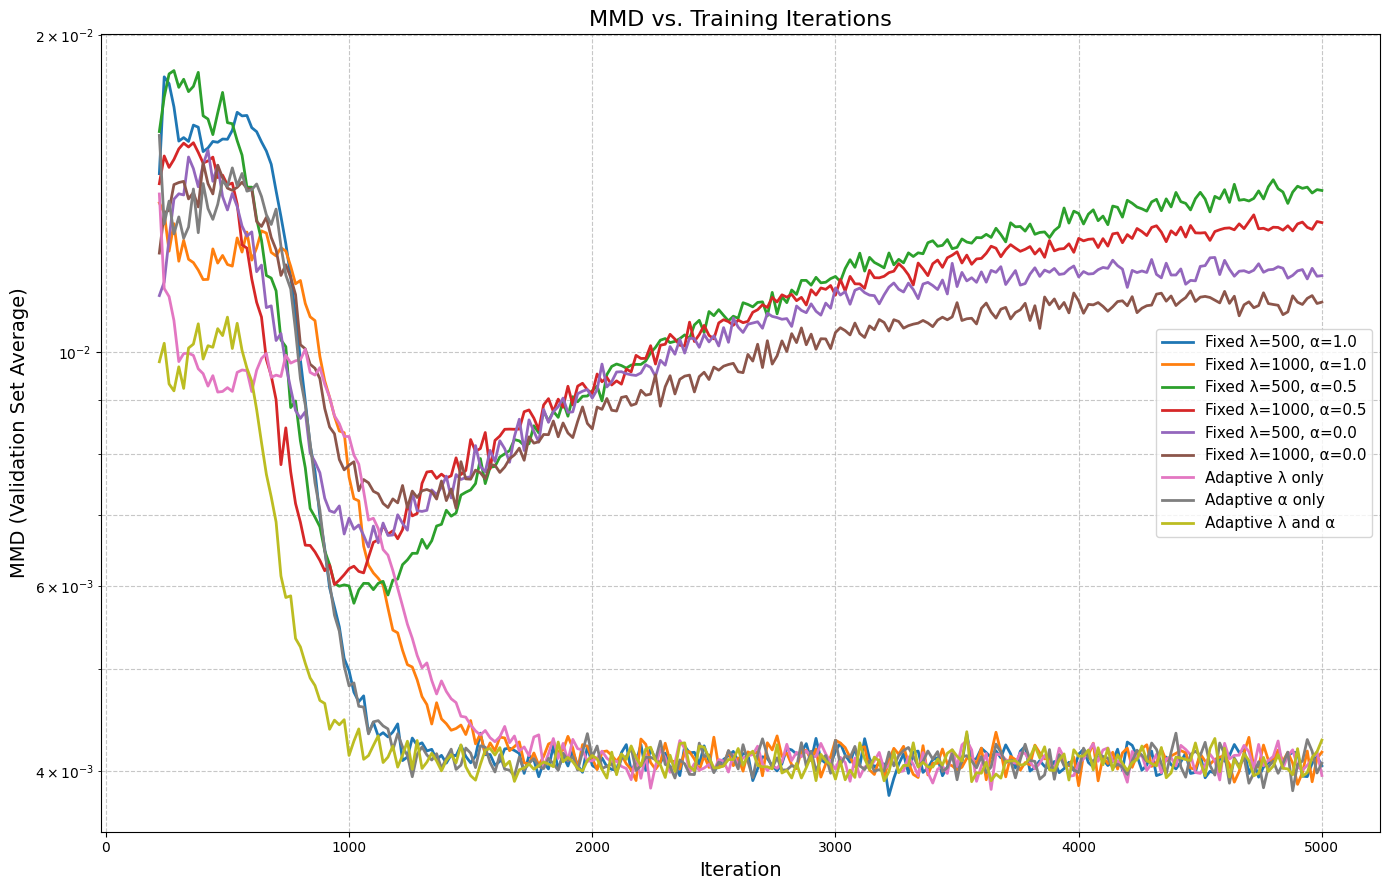

In [ ]:
SKIP = 10

# new x–axis
trimmed_iters = iters_plot[SKIP:]

plt.figure(figsize=(14, 9))
for name, vals in mmd_curves.items():

    trimmed_vals = vals[SKIP:]
    plt.plot(trimmed_iters, trimmed_vals, linewidth=2, label=name)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('MMD (Validation Set Average)', fontsize=14)
plt.yscale('log')
plt.grid(which='both', linestyle='--', alpha=0.7)
plt.title('MMD vs. Training Iterations', fontsize=16)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


# 7️⃣ Experiment 2: Divergence Substitution — single train per (model, dim)


In [ ]:
import time
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from itertools import cycle
import inspect

# ──────────────────────────────────────────────────────────────────────────────
# Assume InfoVAE_* classes, rbf_mmd_eval, Encoder, Decoder, reparam, etc.
# are defined above exactly as you have them.
# ──────────────────────────────────────────────────────────────────────────────

# ----------------------------------------------------------------------------
# 1) Build fixed validation batches once
# ----------------------------------------------------------------------------
sigma          = 1.0
val_K          = 500
val_batch_size = 128

val_batches = []
temp_loader = DataLoader(val_ds, batch_size=val_batch_size, shuffle=False)
for i, (x, _) in enumerate(temp_loader):
    if i >= val_K: break
    val_batches.append(x.to(DEVICE).float())


def rbf_mmd_eval(x, y, sigma):
    x = x.view(x.size(0), -1); y = y.view(y.size(0), -1)
    N, M = x.size(0), y.size(0)

    # Prevent division by zero if batch size is too small
    if N < 2 or M < 2:
        return 0.0

    xx = (x*x).sum(1, keepdim=True); yy = (y*y).sum(1, keepdim=True)
    dxx = xx - 2*(x@x.t()) + xx.t()
    dyy = yy - 2*(y@y.t()) + yy.t()
    dxy = xx - 2*(x@y.t()) + yy.t()

    Kxx = torch.exp(-dxx/(2*sigma**2))
    Kyy = torch.exp(-dyy/(2*sigma**2))
    Kxy = torch.exp(-dxy/(2*sigma**2))

    # Unbiased estimator
    sum_xx = Kxx.sum() - Kxx.diagonal().sum()
    sum_yy = Kyy.sum() - Kyy.diagonal().sum()
    mmd2 = sum_xx/(N*(N-1)) + sum_yy/(M*(M-1)) - 2*Kxy.mean()

    return torch.sqrt(torch.clamp(mmd2, min=0.0)).item()


# ----------------------------------------------------------------------------
# 2) One‐epoch trainer (records avg per‐sample MMD from model.loss stats)
# ----------------------------------------------------------------------------
def train_one_epoch_mmd(model, optimizer, loader, device, sigma):
    model.train()
    mmd_accum = 0.0
    n_batches = 0
    for x, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, lv, z = model(x)
        loss, _ = model.loss(x, recon, mu, lv, z)
        loss.backward()
        optimizer.step()

        # true per-batch MMD via unbiased eval
        p = torch.randn_like(z)
        batch_mmd = rbf_mmd_eval(z, p, sigma)
        mmd_accum += batch_mmd
        n_batches += 1

    return mmd_accum / n_batches

# ----------------------------------------------------------------------------
# 3) Experiment driver
# ----------------------------------------------------------------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dims = [2, 5, 10, 20, 40, 60, 80]
divergences = {
    'MMD':      InfoVAE_MMD,
    'Stein':    InfoVAE_Stein,
    'Sinkhorn': InfoVAE_Sinkhorn,
    'Cramer':   InfoVAE_Cramer,
    'Chi2':     InfoVAE_Chi2,
}
num_epochs = 10

train_mmd_hist = {name: {d: [] for d in dims} for name in divergences}
test_mmd       = {name: [] for name in divergences}
ss_error       = {name: [] for name in divergences}
train_times    = {name: {d: 0.0 for d in dims} for name in divergences}

for name, ModelCls in tqdm(divergences.items(), desc="Divergences"):
    # precompute which extra kwargs to pass into this class
    sig = inspect.signature(ModelCls.__init__)
    accepts_sigma = 'sigma' in sig.parameters
    accepts_blur  = 'blur'  in sig.parameters

    for d in tqdm(dims, desc=f"{name} dims", leave=False):
        # build the instantiation kwarg‐dict dynamically
        init_kwargs = {
            'z_dim': d,
            'alpha': 1.0,
            'lam':   1000.0,
        }
        if accepts_sigma:
            init_kwargs['sigma'] = sigma
        if accepts_blur:
            init_kwargs['blur'] = 0.1

        model     = ModelCls(**init_kwargs).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        # — train & record train‐MMD —
        t0 = time.time()
        for _ in tqdm(range(num_epochs),
              desc=f"{name} | z={d} | Epochs",
              leave=False):
            avg_mmd = train_one_epoch_mmd(model, optimizer, train_loader, DEVICE, sigma)
            train_mmd_hist[name][d].append(avg_mmd)
        train_times[name][d] = time.time() - t0

        # — validation MMD on held‐out val_batches —
        model.eval()
        with torch.no_grad():
            v_mmds = []
            for vx in val_batches:
                z = model(vx)[-1]              # get latent
                p = torch.randn_like(z)
                v_mmds.append(rbf_mmd_eval(z, p, sigma))
            test_mmd[name].append(float(np.mean(v_mmds)))

        # — semi-supervised SVM on only 1 000 labels (100 per class) —
        # gather all train latents + labels
        Z_list, Y_list = [], []
        for x, y in train_loader:
            _,_,_,z = model(x.to(DEVICE))
            Z_list.append(z.detach().cpu().numpy())
            Y_list.append(y.numpy())
        Z = np.concatenate(Z_list, axis=0)
        Y = np.concatenate(Y_list, axis=0)

        # pick 100 per digit
        rng = np.random.RandomState(0)
        idx = np.concatenate([
            rng.choice(np.where(Y==digit)[0], 100, replace=False)
            for digit in range(10)
        ])
        Z_lab = Z[idx]
        Y_lab = Y[idx]

        # standardize
        scaler = StandardScaler().fit(Z_lab)
        Z_lab = scaler.transform(Z_lab)

        # fit linear SVM
        clf = LinearSVC(max_iter=2000, tol=1e-3).fit(Z_lab, Y_lab)

        # evaluate on full test set
        Zt_list, Yt_list = [], []
        for x, y in test_loader:
            _,_,_,z = model(x.to(DEVICE))
            Zt_list.append(z.detach().cpu().numpy())
            Yt_list.append(y.numpy())
        Zt = np.concatenate(Zt_list, axis=0)
        Yt = np.concatenate(Yt_list, axis=0)
        Zt = scaler.transform(Zt)

        ss_error[name].append(1 - clf.score(Zt, Yt))


Divergences:   0%|          | 0/5 [00:00<?, ?it/s]

MMD dims:   0%|          | 0/7 [00:00<?, ?it/s]

MMD | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

MMD | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

MMD | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

MMD | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

MMD | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

MMD | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

MMD | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Stein dims:   0%|          | 0/7 [00:00<?, ?it/s]

Stein | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Stein | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Stein | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Stein | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Stein | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Stein | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Stein | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Sinkhorn dims:   0%|          | 0/7 [00:00<?, ?it/s]

Sinkhorn | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Sinkhorn | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Sinkhorn | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Sinkhorn | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Sinkhorn | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Sinkhorn | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Sinkhorn | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Cramer dims:   0%|          | 0/7 [00:00<?, ?it/s]

Cramer | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Cramer | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Cramer | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Cramer | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Cramer | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Cramer | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Cramer | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Chi2 dims:   0%|          | 0/7 [00:00<?, ?it/s]

Chi2 | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Chi2 | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Chi2 | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Chi2 | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Chi2 | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Chi2 | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Chi2 | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_mmd_hist

{'MMD': {2: [0.028638067511815173,
   0.028843836175825147,
   0.03156838266916079,
   0.03478033694116425,
   0.04216035203930979,
   0.03445214687259559,
   0.03888410209927496,
   0.03528751469420278,
   0.03448507611604487,
   0.03401466440277007],
  5: [0.038078256861761355,
   0.04695455591476818,
   0.05738900610581217,
   0.05664357363568592,
   0.053524949177393415,
   0.05312310866084639,
   0.05218437020953798,
   0.04912380690209709,
   0.049328201023919147,
   0.047730959009520395],
  10: [0.06313849296707713,
   0.06477610431434984,
   0.06391241071277885,
   0.06424200603676633,
   0.06375691998237965,
   0.0643868111603633,
   0.06386962396167749,
   0.06429489551032606,
   0.06377781618616027,
   0.0641090166953644],
  20: [0.010171010953449243,
   0.004655684026121493,
   0.004021171394347156,
   0.004081542498290857,
   0.004035153046638762,
   0.00409818652706106,
   0.004109856790655527,
   0.004038442324039248,
   0.004034275694428038,
   0.004073135040025116],
  

In [ ]:
train_mmd_hist[name][20]

[0.09933432013745931,
 0.007526759233687655,
 0.004065204684852106,
 0.004114518455181147,
 0.004066252464128402,
 0.004051565558989466,
 0.0040691284141701894,
 0.004045635502635373,
 0.0040776939269252365,
 0.004104822623031435]

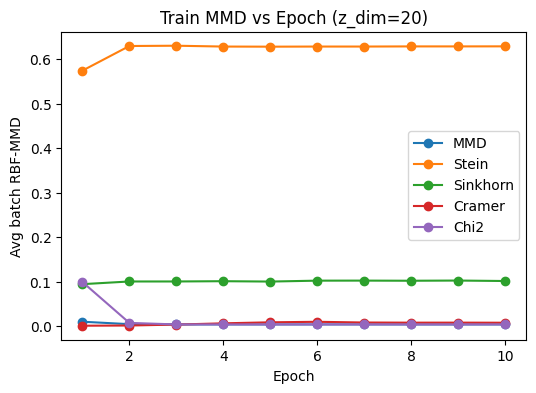

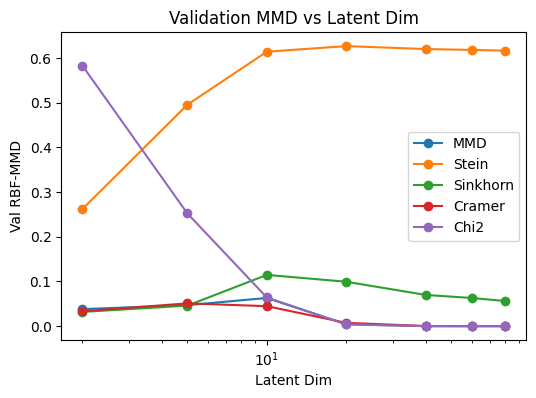

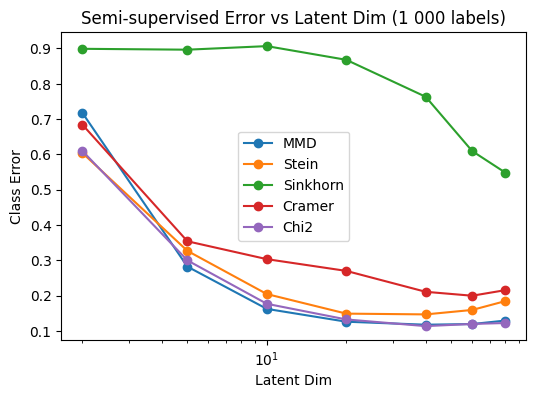

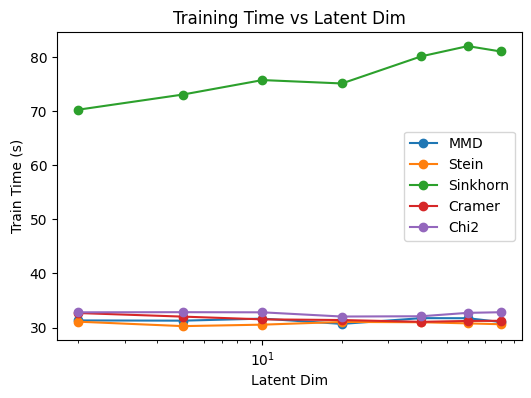

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Plots
# ──────────────────────────────────────────────────────────────────────────────
# a) train‐MMD vs epoch at z_dim=20
plt.figure(figsize=(6,4))
for name in divergences:
    plt.plot(range(1, num_epochs+1),
             train_mmd_hist[name][20],
             marker='o', label=name)
plt.xlabel('Epoch')
plt.ylabel('Avg batch RBF‐MMD')
plt.title('Train MMD vs Epoch (z_dim=20)')
plt.legend()
plt.show()

# b) validation MMD vs latent dim
plt.figure(figsize=(6,4))
for name in divergences:
    plt.plot(dims, test_mmd[name], 'o-', label=name)
plt.xscale('log')
plt.xlabel('Latent Dim')
plt.ylabel('Val RBF‐MMD')
plt.title('Validation MMD vs Latent Dim')
plt.legend()
plt.show()

# c) semi-sup error vs latent dim
plt.figure(figsize=(6,4))
for name in divergences:
    plt.plot(dims, ss_error[name], 'o-', label=name)
plt.xscale('log')
plt.xlabel('Latent Dim')
plt.ylabel('Class Error')
plt.title('Semi-supervised Error vs Latent Dim (1 000 labels)')
plt.legend()
plt.show()

# d) training time vs latent dim
plt.figure(figsize=(6,4))
for name in divergences:
    times = [train_times[name][d] for d in dims]
    plt.plot(dims, times, 'o-', label=name)
plt.xscale('log')
plt.xlabel('Latent Dim')
plt.ylabel('Train Time (s)')
plt.title('Training Time vs Latent Dim')
plt.legend()
plt.show()

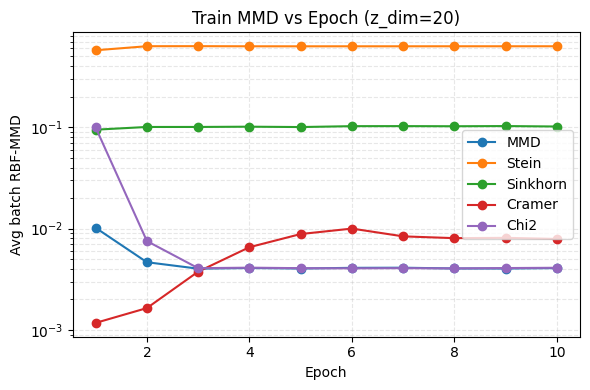

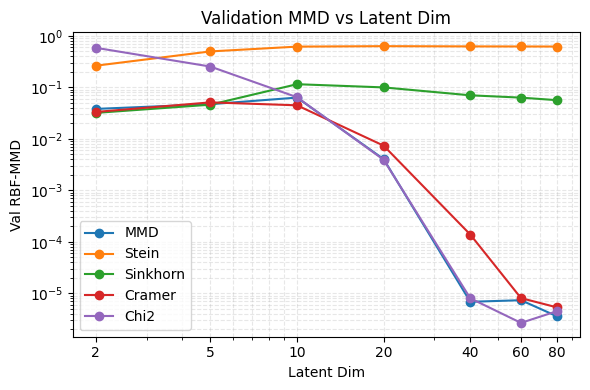

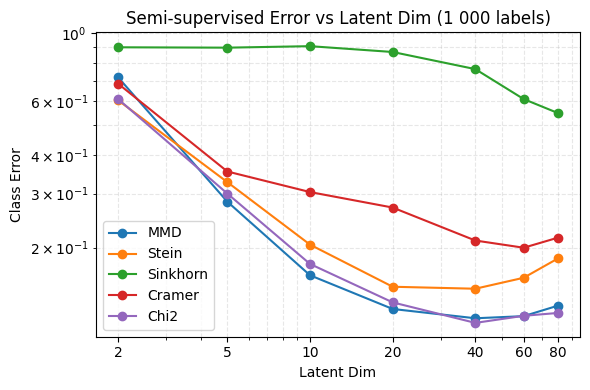

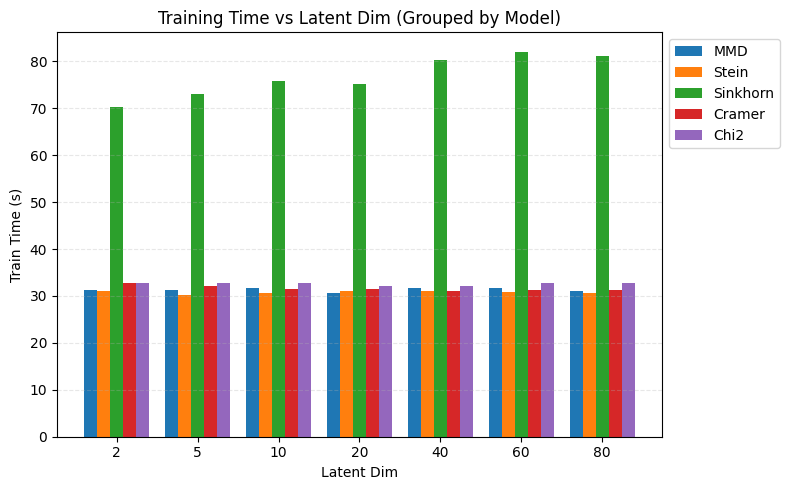

In [ ]:
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# 4) Plots
# ──────────────────────────────────────────────────────────────────────────────

# a) train‐MMD vs epoch at z_dim=20 (log‐scaled y)
plt.figure(figsize=(6,4))
for name in divergences:
    plt.plot(
        range(1, num_epochs+1),
        train_mmd_hist[name][20],
        marker='o', linestyle='-',
        label=name
    )
plt.xlabel('Epoch')
plt.ylabel('Avg batch RBF-MMD')
plt.title('Train MMD vs Epoch (z_dim=20)')
plt.yscale('log')               # <-- log‐scale y
plt.grid(which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# b) validation MMD vs latent dim (force actual dims on x)
plt.figure(figsize=(6,4))
for name in divergences:
    plt.plot(dims, test_mmd[name], 'o-', label=name)
plt.xscale('log')
plt.yscale('log')
plt.xticks(dims, labels=dims)  # <-- show actual dims
plt.xlabel('Latent Dim')
plt.ylabel('Val RBF-MMD')
plt.title('Validation MMD vs Latent Dim')
plt.grid(which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# c) semi-sup error vs latent dim (same as before)
plt.figure(figsize=(6,4))
for name in divergences:
    plt.plot(dims, ss_error[name], 'o-', label=name)
plt.xscale('log')
plt.yscale('log')
plt.xticks(dims, labels=dims)
plt.xlabel('Latent Dim')
plt.ylabel('Class Error')
plt.title('Semi-supervised Error vs Latent Dim')
plt.grid(which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# d) training time vs latent dim → grouped bar chart
plt.figure(figsize=(8,5))
n_models   = len(divergences)
bar_width  = 0.8 / n_models
x_positions = np.arange(len(dims))

for i, name in enumerate(divergences):
    times = [train_times[name][d] for d in dims]
    plt.bar(
        x_positions + i*bar_width,
        times,
        width=bar_width,
        label=name
    )

# label the x‐axis with the actual dims, centered under each group
plt.xticks(
    x_positions + bar_width*(n_models-1)/2,
    labels=dims
)
plt.xlabel('Latent Dim')
plt.ylabel('Train Time (s)')
plt.title('Training Time vs Latent Dim (Grouped by Model)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import json

# 1) Gather everything into one big dict
all_results = {
    "train_mmd_hist": train_mmd_hist,
    "validation_mmd": test_mmd,
    "semi_sup_error": ss_error,
    "train_times": train_times
}

# 2) Recursively convert any numpy / torch types to Python built-ins
def to_builtin(obj):
    if isinstance(obj, dict):
        return {to_builtin(k): to_builtin(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_builtin(v) for v in obj]
    # torch and numpy numbers
    try:
        # torch Tensor scalar or numpy scalar
        import torch, numpy as np
        if isinstance(obj, (torch.Tensor, np.generic)):
            return obj.item()
    except ImportError:
        pass
    # builtin types: int, float, str, bool, None
    return obj

serializable = to_builtin(all_results)

# 3) Dump to disk
with open("infoVAE_results.json", "w") as f:
    json.dump(serializable, f, indent=2)

print("Saved all results to infoVAE_results.json")


Saved all results to infoVAE_results.json


# 8️⃣ Experiment 3: General Model Comparison — single train per (model, dim)


In [ ]:
# new flexible decoder

import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------------------------------------------------------
# helper: a masked Conv2d (type A for first layer, type B thereafter)
# ----------------------------------------------------------------------------
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        assert mask_type in ('A', 'B')
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        yc, xc = kH // 2, kW // 2

        # build mask:
        self.mask.fill_(1)
        self.mask[:, :, yc, xc + (mask_type=='B'):] = 0
        self.mask[:, :, yc+1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)


# ----------------------------------------------------------------------------
# Replacement Decoder: z → feature map → masked‐CNN → pixels
# ----------------------------------------------------------------------------
class Decoder(nn.Module):
    def __init__(self, z_dim=20, hidden=128, n_layers=5):
        """
        z_dim:   size of your latent code
        hidden:  number of feature‐maps in the PixelCNN stack
        n_layers: total masked conv layers (including the first A‐type)
        """
        super().__init__()
        self.z_dim    = z_dim
        self.hidden   = hidden
        self.n_layers = n_layers

        # project z into a “spatial” seed of size hidden×H/4×H/4
        self.fc = nn.Linear(z_dim, hidden * (H//4) * (H//4))

        # first masked conv must be type 'A'
        self.masked_layers = nn.ModuleList()
        self.masked_layers.append(
            MaskedConv2d('A', hidden, hidden, kernel_size=3, padding=1)
        )
        # then a stack of type 'B'
        for _ in range(n_layers-1):
            self.masked_layers.append(
                MaskedConv2d('B', hidden, hidden, kernel_size=3, padding=1)
            )

        # finally project back to C channels
        self.out_conv = nn.Conv2d(hidden, C, kernel_size=1)

    def forward(self, z):
        """
        z: tensor of shape [batch, z_dim]

        returns: reconstructions in [0,1], shape [batch, C, H, H]
        """
        B = z.size(0)
        # 1) linear → spatial feature map
        h = self.fc(z)                               # [B, hidden*(H/4)*(H/4)]
        h = F.relu(h)
        h = h.view(B, self.hidden, H//4, H//4)       # [B, hidden, H/4, H/4]

        # 2) upsample back to full H×H via nearest + conv
        h = F.interpolate(h, scale_factor=2, mode='nearest')
        h = F.relu(nn.Conv2d(self.hidden, self.hidden, 3, padding=1).to(h.device)(h))
        h = F.interpolate(h, scale_factor=2, mode='nearest')
        h = F.relu(nn.Conv2d(self.hidden, self.hidden, 3, padding=1).to(h.device)(h))

        # 3) pass through the masked PixelCNN stack
        for conv in self.masked_layers:
            h = F.relu(conv(h))

        # 4) final 1×1 conv → C logits, then sigmoid for [0,1]
        out = torch.sigmoid(self.out_conv(h))
        return out


In [ ]:
class BaseVAE(nn.Module):
    def __init__(self, z_dim=20, beta=1.0, bn=False):
        super().__init__()
        self.enc = Encoder(z_dim=z_dim, bn=bn)
        self.dec = Decoder(z_dim=z_dim)
        self.beta = beta
    def forward(self, x):
        mu, lv = self.enc(x)
        z = reparam(mu, lv)
        return self.dec(z), mu, lv
    def loss(self, x, recon, mu, lv, epoch=None):
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        return bce + self.beta * kld, {'bce': bce.item(), 'kld': kld.item(), 'extra': 0.0}

# vanilla ELBO‐VAE (α=1.0, i.e. β=1.0)
class ELBOVAE(BaseVAE):
    def __init__(self, z_dim=20, bn=False):
        super().__init__(z_dim=z_dim, beta=1.0, bn=bn)
    # inherits forward & loss exactly (BCE + 1·KLD)

# “Reconstruction‐only” auto‐encoder (no KLD at all)
class ReconAE(BaseVAE):
    def __init__(self, z_dim=20, bn=False):
        super().__init__(z_dim=z_dim, beta=0.0, bn=bn)
    def loss(self, x, recon, mu, lv, epoch=None):
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        return bce, {'bce': bce.item(), 'kld': 0.0, 'extra': 0.0}

# Free‐bits VAE (do not penalize any KL‐dim below `fb` nats)
class FreeBitsVAE(BaseVAE):
    def __init__(self, z_dim=20, beta=1.0, free_bits=0.1, bn=False):
        super().__init__(z_dim=z_dim, beta=beta, bn=bn)
        self.free_bits = free_bits

    def loss(self, x, recon, mu, lv, epoch=None):
        B = x.size(0)
        # reconstruction term
        bce = F.binary_cross_entropy(recon, x, reduction='sum')

        # compute per‐dimension KL z‐dim→shape [B, z_dim]
        kld_mat = -0.5 * (1 + lv - mu.pow(2) - lv.exp())  # [B, z_dim]
        # average over batch → [z_dim]
        kld_dim = kld_mat.mean(0)
        # apply free‐bits threshold
        kld_dim_clamped = torch.clamp(kld_dim, min=self.free_bits)
        # total KL = sum dims * batch_size
        kld_fb = kld_dim_clamped.sum() * B

        total = bce + self.beta * kld_fb
        return total, {
            'bce': bce.item(),
            'kld': kld_fb.item(),
            'free_bits': self.free_bits
        }


# β-VAE (beta parameter)
class BetaVAE(BaseVAE):
    def __init__(self, z_dim=20, beta=4.0, bn=False):
        super().__init__(z_dim=z_dim, beta=beta, bn=bn)

# BN‑VAE (batchnorm in encoder)
class BNVAE(BaseVAE):
    def __init__(self, z_dim=20):
        super().__init__(z_dim=z_dim, beta=1.0, bn=True)


In [ ]:
# AAE (Adversarial Autoencoder)
class Discriminator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim,128), nn.ReLU(),
            nn.Linear(128,1)
        )
    def forward(self, z): return self.net(z)

class AAE(nn.Module):
    def __init__(self, z_dim=20):
        super().__init__()
        self.enc = Encoder(z_dim=z_dim)
        self.dec = Decoder(z_dim=z_dim)
        self.disc = Discriminator(z_dim).to(DEVICE)
        self.opt_d = optim.Adam(self.disc.parameters(), lr=1e-4)
    def forward(self, x):
        mu, lv = self.enc(x)
        z = reparam(mu, lv)
        return self.dec(z), mu, lv, z
    def loss(self, x, recon, mu, lv, z, epoch=None):
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        # train discriminator
        real = torch.randn_like(z)
        d_real = self.disc(real)
        d_fake = self.disc(z.detach())
        ld = F.binary_cross_entropy_with_logits(d_real, torch.ones_like(d_real)) + \
             F.binary_cross_entropy_with_logits(d_fake, torch.zeros_like(d_fake))
        self.opt_d.zero_grad(); ld.backward(); self.opt_d.step()
        # generator loss
        g_loss = F.binary_cross_entropy_with_logits(self.disc(z), torch.ones_like(d_fake))
        return bce + g_loss, {'bce': bce.item(), 'kld': 0.0, 'extra': g_loss.item()}

In [ ]:
# InfoVAE-Stein (kernelized Stein discrepancy)
def ksd_rbf(z, sigma=1.0):
    """
    Kernelized Stein discrepancy for q(z)=Empirical vs. p(z)=N(0,I)
    Using the RBF kernel k(z,z')=exp(-||z-z'||^2/(2σ^2)).
    """
    B, D = z.size()
    # pairwise differences
    z_i = z.unsqueeze(1)           # [B,1,D]
    z_j = z.unsqueeze(0)           # [1,B,D]
    diff = z_i - z_j               # [B,B,D]

    # kernel matrix
    K = torch.exp(-(diff.pow(2).sum(-1)) / (2 * sigma**2))  # [B,B]

    # score_p = ∇_z log p(z) with p=N(0,I) → -z
    s_i = -z_i                     # [B,1,D]
    s_j = -z_j                     # [1,B,D]

    # term1: s_iᵀ s_j * K  → shape [B,B]
    t1 = (s_i * s_j).sum(-1) * K

    # term2: s_iᵀ ∇_{z_j} k = s_iᵀ [ (z_i-z_j)/σ² * K ]  → shape [B,B]
    grad_j_K = diff / (sigma**2) * K.unsqueeze(-1)  # [B,B,D]
    t2       = (s_i * grad_j_K).sum(-1)

    # term3: s_jᵀ ∇_{z_i} k = s_jᵀ [ -(z_i-z_j)/σ² * K ]  → shape [B,B]
    grad_i_K = -grad_j_K
    t3       = (s_j * grad_i_K).sum(-1)

    U = t1 + t2 + t3              # [B,B]
    return U.mean()               # scalar

class InfoVAE_Stein(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0, sigma=1.0):
        super().__init__()
        self.enc, self.dec = Encoder(z_dim), Decoder(z_dim)
        self.alpha, self.lam, self.sigma = alpha, lam, sigma

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        B = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        stein = ksd_rbf(z, sigma=self.sigma) * B
        total = bce + (1-self.alpha)*kld + (self.alpha+self.lam-1)*stein
        return total, {'bce':bce.item(),'kld':kld.item(),'stein':stein.item()}


# InfoVAE-MMD (your original)
def mmd_rbf(q, p, sigma=1.0):
    def pd2(a,b): return torch.cdist(a,b).pow(2)
    Kqq = torch.exp(-pd2(q,q)/(2*sigma**2)).mean()
    Kpp = torch.exp(-pd2(p,p)/(2*sigma**2)).mean()
    Kqp = torch.exp(-pd2(q,p)/(2*sigma**2)).mean()
    return Kqq + Kpp - 2*Kqp

class InfoVAE_MMD(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0, sched=None, sigma=1.0):
        super().__init__()
        self.enc, self.dec = Encoder(z_dim), Decoder(z_dim)
        self.alpha, self.lam, self.sched, self.sigma = alpha, lam, sched, sigma

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        alpha, lam = (self.alpha,self.lam) if self.sched is None else self.sched(epoch)
        B   = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        mmd = mmd_rbf(z, torch.randn_like(z), sigma=self.sigma) * B
        total = bce + (1-alpha)*kld + (alpha+lam-1)*mmd
        return total, {'bce':bce.item(),'kld':kld.item(),'mmd':mmd.item(),
                       'alpha':alpha,'lam':lam}


# InfoVAE-Sinkhorn (entropic OT via geomloss)
class InfoVAE_Sinkhorn(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0, blur=0.1):
        super().__init__()
        self.enc   = Encoder(z_dim)
        self.dec   = Decoder(z_dim)
        self.blur  = blur
        # geomloss SamplesLoss("sinkhorn") computes the Sinkhorn divergence
        self.sinkhorn = SamplesLoss("sinkhorn", p=2, blur=blur)
        self.alpha, self.lam = alpha, lam

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        B   = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        # Sinkhorn divergence between q(z) and p(z)=N(0,I)
        prior = torch.randn_like(z)
        sink = self.sinkhorn(z, prior) * B
        total = bce + (1-self.alpha)*kld + (self.alpha+self.lam-1)*sink
        return total, {'bce':bce.item(),'kld':kld.item(),'sinkhorn':sink.item()}


# InfoVAE-Cramér (Energy distance)
def cramer_distance(q, p):
    """
    Cramér (a.k.a. energy) distance:
      E||q−p|| − 1/2 E||q−q'|| − 1/2 E||p−p'||
    """
    d_qp = torch.cdist(q, p, p=2).mean()
    d_qq = torch.cdist(q, q, p=2).mean()
    d_pp = torch.cdist(p, p, p=2).mean()
    return d_qp - 0.5*d_qq - 0.5*d_pp

class InfoVAE_Cramer(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0):
        super().__init__()
        self.enc, self.dec = Encoder(z_dim), Decoder(z_dim)
        self.alpha, self.lam = alpha, lam

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        B   = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())

        # energy distance vs. standard normal
        prior = torch.randn_like(z)
        crim  = cramer_distance(z, prior) * B

        total = bce + (1-self.alpha)*kld + (self.alpha+self.lam-1)*crim
        return total, {
            'bce':   bce.item(),
            'kld':   kld.item(),
            'cramer': crim.item()
        }


class InfoVAE_Chi2(nn.Module):
    def __init__(self, z_dim=20, alpha=0.5, lam=10.0, lr=1e-4):
        super().__init__()
        self.enc   = Encoder(z_dim)
        self.dec   = Decoder(z_dim)
        self.T_net = nn.Sequential(
            nn.Linear(z_dim, 128), nn.ReLU(),
            nn.Linear(128, 1)
        ).to(DEVICE)
        self.opt_T = optim.Adam(self.T_net.parameters(), lr=lr)
        self.alpha, self.lam = alpha, lam

    def forward(self, x):
        mu, lv = self.enc(x)
        z      = reparam(mu, lv)
        return self.dec(z), mu, lv, z

    def loss(self, x, recon, mu, lv, z, epoch=None):
        B   = x.size(0)
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())

        # ── 1) Update T_net *only* via detached z, so we never touch the VAE graph
        z_det     = z.detach()                      # <— detach here!
        z_prior   = torch.randn_like(z_det)
        T_q       = self.T_net(z_det)
        T_p       = self.T_net(z_prior)
        loss_T    = -(T_q.mean() - (T_p + 0.25 * T_p.pow(2)).mean())
        self.opt_T.zero_grad()
        loss_T.backward()                           # only flows into T_net
        self.opt_T.step()

        # ── 2) Compute the χ² term *without* no_grad, but it only uses bce/kld
        with torch.no_grad():
            # we keep the same formula so χ² enters as a constant
            T_q2  = self.T_net(z_det)
            T_p2  = self.T_net(z_prior)
            chi2  = (T_q2.mean() - (T_p2 + 0.25*T_p2.pow(2)).mean()) * B

        total = bce + (1-self.alpha)*kld + (self.alpha+self.lam-1)*chi2
        return total, {
            'bce':  bce.item(),
            'kld':  kld.item(),
            'chi2': chi2.item()
        }




In [ ]:
# ContrastiveAE<

def cosine_sim_matrix(z):
    zn = F.normalize(z, dim=1)
    return torch.matmul(zn, zn.t())

class ContrastiveAE(nn.Module):
    def __init__(self, z_dim=20, beta=1.0, w=10.0):
        super().__init__()
        self.enc = Encoder(z_dim)
        self.dec = Decoder(z_dim)
        self.beta, self.w = beta, w
    def forward(self, x):
        mu, lv = self.enc(x)
        z = reparam(mu, lv)
        return self.dec(z), mu, lv, z
    def nce(self, z):
        sim = cosine_sim_matrix(z)
        logits = sim / 0.1
        labels = torch.arange(z.size(0), device=z.device)
        return F.cross_entropy(logits, labels) * z.size(0)
    def loss(self, x, recon, mu, lv, z, epoch=None):
        bce = F.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
        nce = self.nce(z)
        total = bce + self.beta*kld + self.w*nce
        return total, {'bce': bce.item(), 'kld': kld.item(), 'extra': nce.item()}

In [ ]:
import time
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn.svm import LinearSVC
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------------------
# 1) fixed_params + MMD evaluator (unbiased)
# ----------------------------------------------------------------------------
sigma_default  = 1.0

def rbf_mmd_eval(x, y, sigma):
    x = x.view(x.size(0), -1)
    y = y.view(y.size(0), -1)
    N, M = x.size(0), y.size(0)
    if N < 2 or M < 2:
        return 0.0
    xx = (x*x).sum(1, keepdim=True)
    yy = (y*y).sum(1, keepdim=True)
    dxx = xx - 2*(x@x.t()) + xx.t()
    dyy = yy - 2*(y@y.t()) + yy.t()
    dxy = xx - 2*(x@y.t()) + yy.t()
    Kxx = torch.exp(-dxx/(2*sigma**2))
    Kyy = torch.exp(-dyy/(2*sigma**2))
    Kxy = torch.exp(-dxy/(2*sigma**2))
    sum_xx = Kxx.sum() - Kxx.diagonal().sum()
    sum_yy = Kyy.sum() - Kyy.diagonal().sum()
    mmd2 = sum_xx/(N*(N-1)) + sum_yy/(M*(M-1)) - 2*Kxy.mean()
    return torch.sqrt(torch.clamp(mmd2, min=0.0)).item()

# ----------------------------------------------------------------------------
# 2) one‐epoch trainer (only needed for the MMD‐VAE, but we'll reuse it)
# ----------------------------------------------------------------------------
def train_one_epoch(model, opt, loader, device):
    model.train()
    for x, _ in loader:
        x = x.to(device)
        opt.zero_grad()
        # InfoVAE returns recon, mu, lv, z; others return recon, mu, lv
        out = model(x)
        if len(out) == 4:
            recon, mu, lv, z = out
        else:
            recon, mu, lv  = out
            z              = reparam(mu, lv)
        loss, _ = model.loss(x, recon, mu, lv, z)
        loss.backward()
        opt.step()


In [ ]:
# ----------------------------------------------------------------------------
# 1) Experiment settings
# ----------------------------------------------------------------------------
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dims          = [2, 5, 10, 20, 40, 60, 80]
models        = {
    "ELBOVAE":       ELBOVAE,
    "ReconAE":       ReconAE,
    "FreeBitsVAE":   FreeBitsVAE,
    "BNVAE":         BNVAE,
    "BetaVAE":       BetaVAE,
    "AAE":           AAE,
    "InfoVAE-MMD":   InfoVAE_MMD,
    "ContrastiveAE": ContrastiveAE,
}
num_epochs    = 10
sigma_default = 1.0   # fallback for models without sigma
val_K          = 500
val_batch_size = 128

val_batches = []
temp_loader = DataLoader(val_ds, batch_size=val_batch_size, shuffle=False)
for i, (x, _) in enumerate(temp_loader):
    if i >= val_K: break
    val_batches.append(x.to(DEVICE).float())

# storage
train_times = {name: {d: 0.0 for d in dims} for name in models}
results     = {name: {'mmd': [], 'recon': [], 'ss_err': []} for name in models}
trained_states  = {}

# ----------------------------------------------------------------------------
# 2) Main loop
# ----------------------------------------------------------------------------
for name, Cls in tqdm(models.items(), desc="Models"):
    for d in tqdm(dims, desc=f"{name}", leave=False):
        # 2a) instantiate & train
        #    if your model __init__ takes extra args, add them here
        model = Cls(z_dim=d).to(DEVICE)
        opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

        t0 = time.time()
        for _ in tqdm(range(num_epochs),
              desc=f"{name} | z={d} | Epochs",
              leave=False):
            train_one_epoch(model, opt, train_loader, DEVICE)
        train_times[name][d] = time.time() - t0

        trained_states[(name, d)] = model.state_dict()

        # 2b) MMD on held-out val_batches
        sigma = getattr(model, 'sigma', sigma_default)
        with torch.no_grad():
            zs = [ model(vx)[-1] for vx in val_batches ]
            Zv = torch.cat(zs, dim=0)
            Pv = torch.randn_like(Zv)
            mmd_val = rbf_mmd_eval(Zv, Pv, sigma)
        results[name]['mmd'].append(mmd_val)

        # 2c) reconstruction error (BCE) on test set
        tot_recon, n = 0.0, 0
        for x, _ in test_loader:
            recon = model(x.to(DEVICE))[0]
            tot_recon += F.binary_cross_entropy(
                recon, x.to(DEVICE), reduction='sum'
            ).item()
            n += x.size(0)
        results[name]['recon'].append(tot_recon / n)

        # 2d) semi-supervised error with 100 labels per class
        #    collect all train latents + labels
        Z_list, Y_list = [], []
        for x, y in train_loader:
            z = model(x.to(DEVICE))[-1].detach().cpu().numpy()
            Z_list.append(z)
            Y_list.append(y.numpy())
        Z = np.concatenate(Z_list, axis=0)
        Y = np.concatenate(Y_list, axis=0)

        # pick 100 per class
        rng = np.random.RandomState(0)
        idx = np.concatenate([
            rng.choice(np.where(Y == c)[0], 100, replace=False)
            for c in np.unique(Y)
        ])
        Z_lab = Z[idx]
        Y_lab = Y[idx]

        # standardize, train linear SVM
        scaler = StandardScaler().fit(Z_lab)
        Z_lab = scaler.transform(Z_lab)
        clf   = LinearSVC(max_iter=2000, tol=1e-3).fit(Z_lab, Y_lab)

        # evaluate on full test set
        Zt_list, Yt_list = [], []
        for x, y in test_loader:
            z = model(x.to(DEVICE))[-1].detach().cpu().numpy()
            Zt_list.append(z); Yt_list.append(y.numpy())
        Zt = np.concatenate(Zt_list, axis=0)
        Yt = np.concatenate(Yt_list, axis=0)
        Zt = scaler.transform(Zt)

        results[name]['ss_err'].append(1 - clf.score(Zt, Yt))

Models:   0%|          | 0/8 [00:00<?, ?it/s]

ELBOVAE:   0%|          | 0/7 [00:00<?, ?it/s]

ELBOVAE | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ELBOVAE | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ELBOVAE | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ELBOVAE | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ELBOVAE | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ELBOVAE | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ELBOVAE | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ReconAE:   0%|          | 0/7 [00:00<?, ?it/s]

ReconAE | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ReconAE | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ReconAE | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ReconAE | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ReconAE | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ReconAE | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ReconAE | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

FreeBitsVAE:   0%|          | 0/7 [00:00<?, ?it/s]

FreeBitsVAE | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

FreeBitsVAE | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

FreeBitsVAE | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

FreeBitsVAE | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

FreeBitsVAE | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

FreeBitsVAE | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

FreeBitsVAE | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BNVAE:   0%|          | 0/7 [00:00<?, ?it/s]

BNVAE | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BNVAE | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BNVAE | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BNVAE | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BNVAE | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BNVAE | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BNVAE | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BetaVAE:   0%|          | 0/7 [00:00<?, ?it/s]

BetaVAE | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BetaVAE | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BetaVAE | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BetaVAE | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BetaVAE | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BetaVAE | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

BetaVAE | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

AAE:   0%|          | 0/7 [00:00<?, ?it/s]

AAE | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

AAE | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

AAE | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

AAE | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

AAE | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

AAE | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

AAE | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

InfoVAE-MMD:   0%|          | 0/7 [00:00<?, ?it/s]

InfoVAE-MMD | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

InfoVAE-MMD | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

InfoVAE-MMD | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

InfoVAE-MMD | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

InfoVAE-MMD | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

InfoVAE-MMD | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

InfoVAE-MMD | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ContrastiveAE:   0%|          | 0/7 [00:00<?, ?it/s]

ContrastiveAE | z=2 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ContrastiveAE | z=5 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ContrastiveAE | z=10 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ContrastiveAE | z=20 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ContrastiveAE | z=40 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ContrastiveAE | z=60 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ContrastiveAE | z=80 | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
models

{'ELBOVAE': __main__.ELBOVAE,
 'ReconAE': __main__.ReconAE,
 'FreeBitsVAE': __main__.FreeBitsVAE,
 'BNVAE': __main__.BNVAE,
 'BetaVAE': __main__.BetaVAE,
 'AAE': __main__.AAE,
 'InfoVAE-MMD': __main__.InfoVAE_MMD,
 'ContrastiveAE': __main__.ContrastiveAE}

In [ ]:
models

{'ELBOVAE': __main__.ELBOVAE,
 'ReconAE': __main__.ReconAE,
 'FreeBitsVAE': __main__.FreeBitsVAE,
 'BNVAE': __main__.BNVAE,
 'BetaVAE': __main__.BetaVAE,
 'AAE': __main__.AAE,
 'InfoVAE-MMD': __main__.InfoVAE_MMD,
 'ContrastiveAE': __main__.ContrastiveAE}

In [ ]:
train_times

{'ELBOVAE': {2: 66.59933590888977,
  5: 65.83877086639404,
  10: 66.09489178657532,
  20: 65.81196618080139,
  40: 66.01918959617615,
  60: 66.5324649810791,
  80: 66.73429131507874},
 'ReconAE': {2: 66.67581820487976,
  5: 64.67531132698059,
  10: 64.62097311019897,
  20: 64.90381383895874,
  40: 64.67905020713806,
  60: 64.99240827560425,
  80: 64.94224119186401},
 'FreeBitsVAE': {2: 67.0008864402771,
  5: 66.36831545829773,
  10: 66.26366972923279,
  20: 66.43796849250793,
  40: 66.71157121658325,
  60: 66.50618124008179,
  80: 66.35459446907043},
 'BNVAE': {2: 67.01083564758301,
  5: 66.54794549942017,
  10: 66.67044496536255,
  20: 66.75341820716858,
  40: 66.5709400177002,
  60: 68.1874623298645,
  80: 68.65785551071167},
 'BetaVAE': {2: 66.42520236968994,
  5: 66.0282621383667,
  10: 66.0364351272583,
  20: 66.41331481933594,
  40: 66.1364586353302,
  60: 66.14262771606445,
  80: 66.87197780609131},
 'AAE': {2: 68.87306594848633,
  5: 67.99078512191772,
  10: 68.23249769210815,


In [ ]:
results

{'ELBOVAE': {'mmd': [0.934424638748169,
   0.7099063396453857,
   0.5182710886001587,
   0.33252060413360596,
   0.34957435727119446,
   0.3721650540828705,
   1.0],
  'recon': [170.26183041992186,
   132.63746596679687,
   113.5359812133789,
   105.77642760009766,
   106.93837166748047,
   107.3810009765625,
   206.99406513671875],
  'ss_err': [0.6369,
   0.5912,
   0.2872,
   0.1734,
   0.10340000000000005,
   0.09750000000000003,
   0.902]},
 'ReconAE': {'mmd': [0.827453076839447,
   0.5837027430534363,
   0.4086717665195465,
   0.12488347291946411,
   0.041126176714897156,
   0.03067118301987648,
   0.01062468159943819],
  'recon': [169.239974609375,
   128.50797041015625,
   102.27194543457031,
   89.03638359375,
   83.41102717285156,
   81.1605374633789,
   79.97875815429687],
  'ss_err': [0.6942999999999999,
   0.5253,
   0.36129999999999995,
   0.21409999999999996,
   0.126,
   0.10089999999999999,
   0.08350000000000002]},
 'FreeBitsVAE': {'mmd': [0.9586393237113953,
   0.6853

In [ ]:
import json

# assume `results` and `train_times` are defined as in your notebook
# both are dicts keyed by model name → dicts keyed by latent dim/list

save_results = {}
for model_name, metrics in results.items():
    save_results[model_name] = {
        'mmd':     metrics['mmd'],
        'recon':   metrics['recon'],
        'ss_err':  metrics['ss_err'],
        'train_time': [ train_times[model_name][d] for d in dims ]
    }

# if you also want to include the dims array for reference:
save_results['_meta'] = {'dims': dims}

# write to disk
with open('experiment_results.json', 'w') as f:
    json.dump(save_results, f, indent=2)

print("Wrote results to experiment_results.json")


Wrote results to experiment_results.json


In [ ]:
trained_states.keys()


dict_keys([('ELBOVAE', 2), ('ELBOVAE', 5), ('ELBOVAE', 10), ('ELBOVAE', 20), ('ELBOVAE', 40), ('ELBOVAE', 60), ('ELBOVAE', 80), ('ReconAE', 2), ('ReconAE', 5), ('ReconAE', 10), ('ReconAE', 20), ('ReconAE', 40), ('ReconAE', 60), ('ReconAE', 80), ('FreeBitsVAE', 2), ('FreeBitsVAE', 5), ('FreeBitsVAE', 10), ('FreeBitsVAE', 20), ('FreeBitsVAE', 40), ('FreeBitsVAE', 60), ('FreeBitsVAE', 80), ('BNVAE', 2), ('BNVAE', 5), ('BNVAE', 10), ('BNVAE', 20), ('BNVAE', 40), ('BNVAE', 60), ('BNVAE', 80), ('BetaVAE', 2), ('BetaVAE', 5), ('BetaVAE', 10), ('BetaVAE', 20), ('BetaVAE', 40), ('BetaVAE', 60), ('BetaVAE', 80), ('AAE', 2), ('AAE', 5), ('AAE', 10), ('AAE', 20), ('AAE', 40), ('AAE', 60), ('AAE', 80), ('InfoVAE-MMD', 2), ('InfoVAE-MMD', 5), ('InfoVAE-MMD', 10), ('InfoVAE-MMD', 20), ('InfoVAE-MMD', 40), ('InfoVAE-MMD', 60), ('InfoVAE-MMD', 80), ('ContrastiveAE', 2), ('ContrastiveAE', 5), ('ContrastiveAE', 10), ('ContrastiveAE', 20), ('ContrastiveAE', 40), ('ContrastiveAE', 60), ('ContrastiveAE', 80

In [ ]:
torch.save(trained_states, 'trained_states.pth')

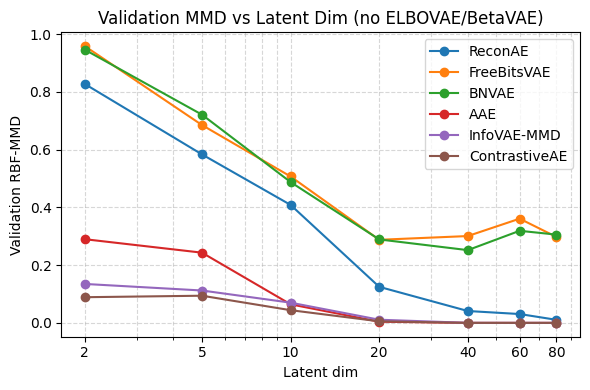

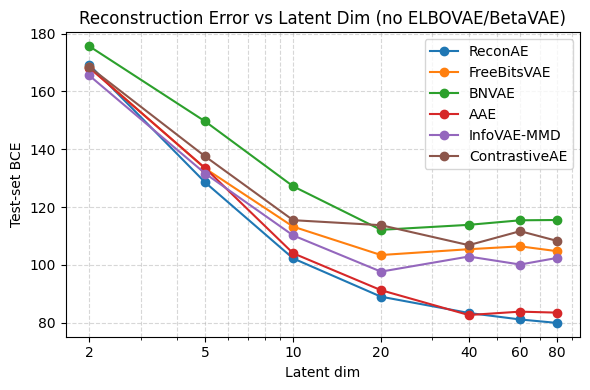

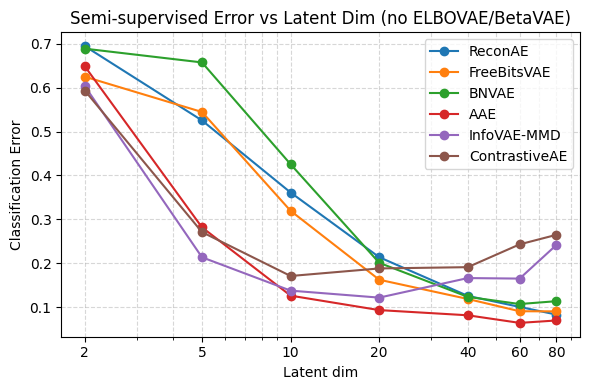

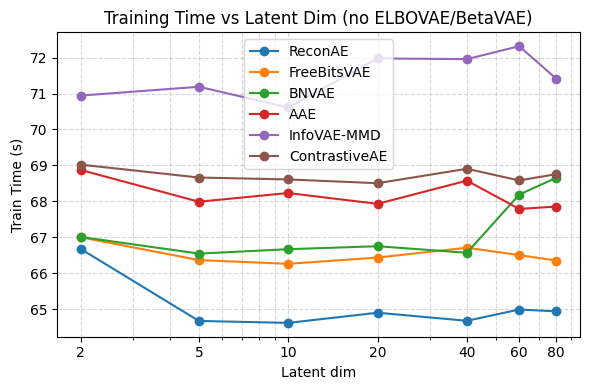

In [ ]:
# build a filtered list of model names
exclude = {"ELBOVAE", "BetaVAE"}
filtered_models = [name for name in models.keys() if name not in exclude]

# a) Validation MMD vs Latent Dim (excluding ELBOVAE & BetaVAE)
plt.figure(figsize=(6,4))
for name in filtered_models:
    plt.plot(dims, results[name]['mmd'], 'o-', label=name)
plt.xscale('log')
plt.xticks(dims, [str(d) for d in dims])
plt.xlabel('Latent dim')
plt.ylabel('Validation RBF-MMD')
plt.title('Validation MMD vs Latent Dim')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# b) Reconstruction BCE vs Latent Dim
plt.figure(figsize=(6,4))
for name in filtered_models:
    plt.plot(dims, results[name]['recon'], 'o-', label=name)
plt.xscale('log')
plt.xticks(dims, [str(d) for d in dims])
plt.xlabel('Latent dim')
plt.ylabel('Test-set BCE')
plt.title('Reconstruction Error vs Latent Dim')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# c) Semi-supervised Error vs Latent Dim
plt.figure(figsize=(6,4))
for name in filtered_models:
    plt.plot(dims, results[name]['ss_err'], 'o-', label=name)
plt.xscale('log')
plt.xticks(dims, [str(d) for d in dims])
plt.xlabel('Latent dim')
plt.ylabel('Classification Error')
plt.title('Semi-supervised Error vs Latent Dim')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# d) Training Time vs Latent Dim
plt.figure(figsize=(6,4))
for name in filtered_models:
    plt.plot(dims, [train_times[name][d] for d in dims], 'o-', label=name)
plt.xscale('log')
plt.xticks(dims, [str(d) for d in dims])
plt.xlabel('Latent dim')
plt.ylabel('Train Time (s)')
plt.title('Training Time vs Latent Dim')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


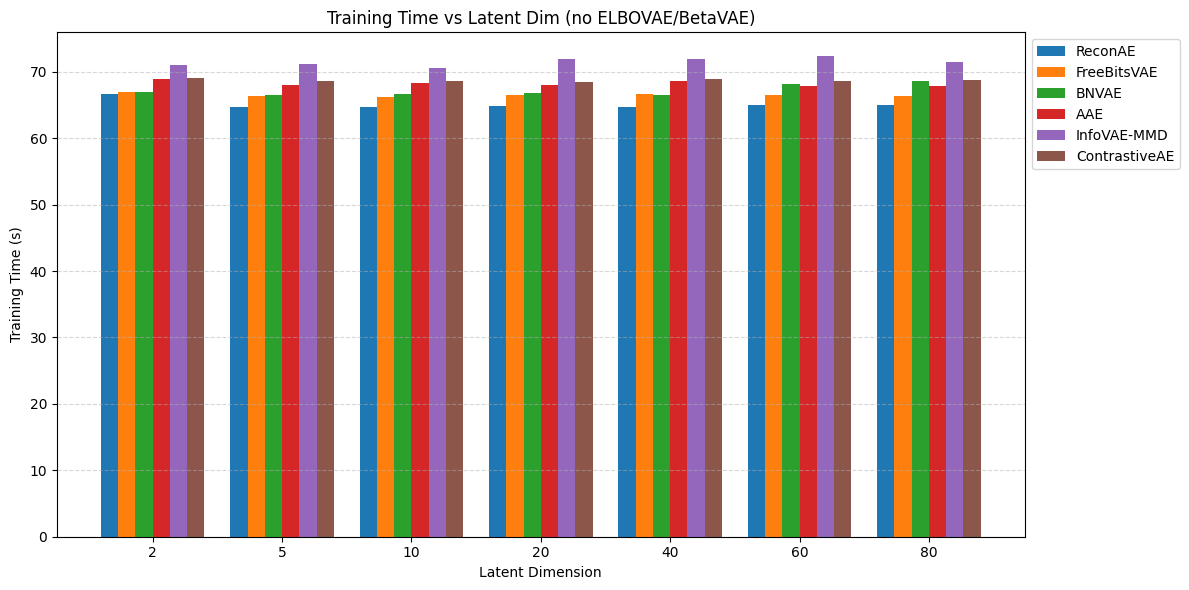

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# which models to plot
exclude        = {"ELBOVAE", "BetaVAE"}
models_to_plot = [m for m in train_times.keys() if m not in exclude]
dims_list      = dims  # your existing list of latent dims

# horizontal locations for each group
x = np.arange(len(dims_list))
width = 0.8 / len(models_to_plot)

plt.figure(figsize=(12,6))
for i, name in enumerate(models_to_plot):
    times = [train_times[name][d] for d in dims_list]
    plt.bar(x + i*width, times, width=width, label=name)

# label the x‐ticks with the actual dims
plt.xticks(x + width*(len(models_to_plot)-1)/2, [str(d) for d in dims_list])
plt.xlabel("Latent Dimension")
plt.ylabel("Training Time (s)")
plt.title("Training Time vs Latent Dim (no ELBOVAE/BetaVAE)")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

latent_dim_plot = dims[6]

# 1) Grab exactly one example of each digit from the test set
digits_needed = set(range(10))
examples = {}
for x, y in test_loader:
    for img, label in zip(x, y):
        lbl = int(label.item())
        if lbl in digits_needed:
            examples[lbl] = img.unsqueeze(0).to(DEVICE)
            digits_needed.remove(lbl)
        if not digits_needed:
            break
    if not digits_needed:
        break

# Stack into [10, C, H, W], row order 0…9
ordered_imgs = torch.cat([examples[d] for d in range(10)], dim=0)

# 2) Make a (10 rows) × (1 + M models) grid
model_items = list(models.items())
n_models    = len(model_items)
n_cols      = n_models + 1   # extra for originals

fig, axes = plt.subplots(10, n_cols,
                         figsize=(2*n_cols, 2*10),
                         sharex=True, sharey=True)

# If only one row/one column edge-case
if axes.ndim == 1:
    axes = axes[np.newaxis, :]

# 3) Plot
for row in range(10):
    # first column: the original
    ax = axes[row, 0]
    ax.imshow(ordered_imgs[row].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if row == 0:
        axes[row, 0].set_title("Original")

# now each model in columns 1…n_cols-1
for col, (name, Cls) in enumerate(model_items, start=1):
    # instantiate + load
    m = Cls(z_dim=latent_dim_plot).to(DEVICE)
    m.load_state_dict(trained_states[(name, latent_dim_plot)])
    m.eval()

    with torch.no_grad():
        # feed the entire 10-batch
        recon_batch, *_ = m(ordered_imgs)

    for row in range(10):
        ax = axes[row, col]
        ax.imshow(recon_batch[row].cpu().squeeze(), cmap='gray')
        ax.axis('off')
        if row == 0:
            axes[row, col].set_title(name, fontsize=10)

plt.tight_layout()
plt.show()



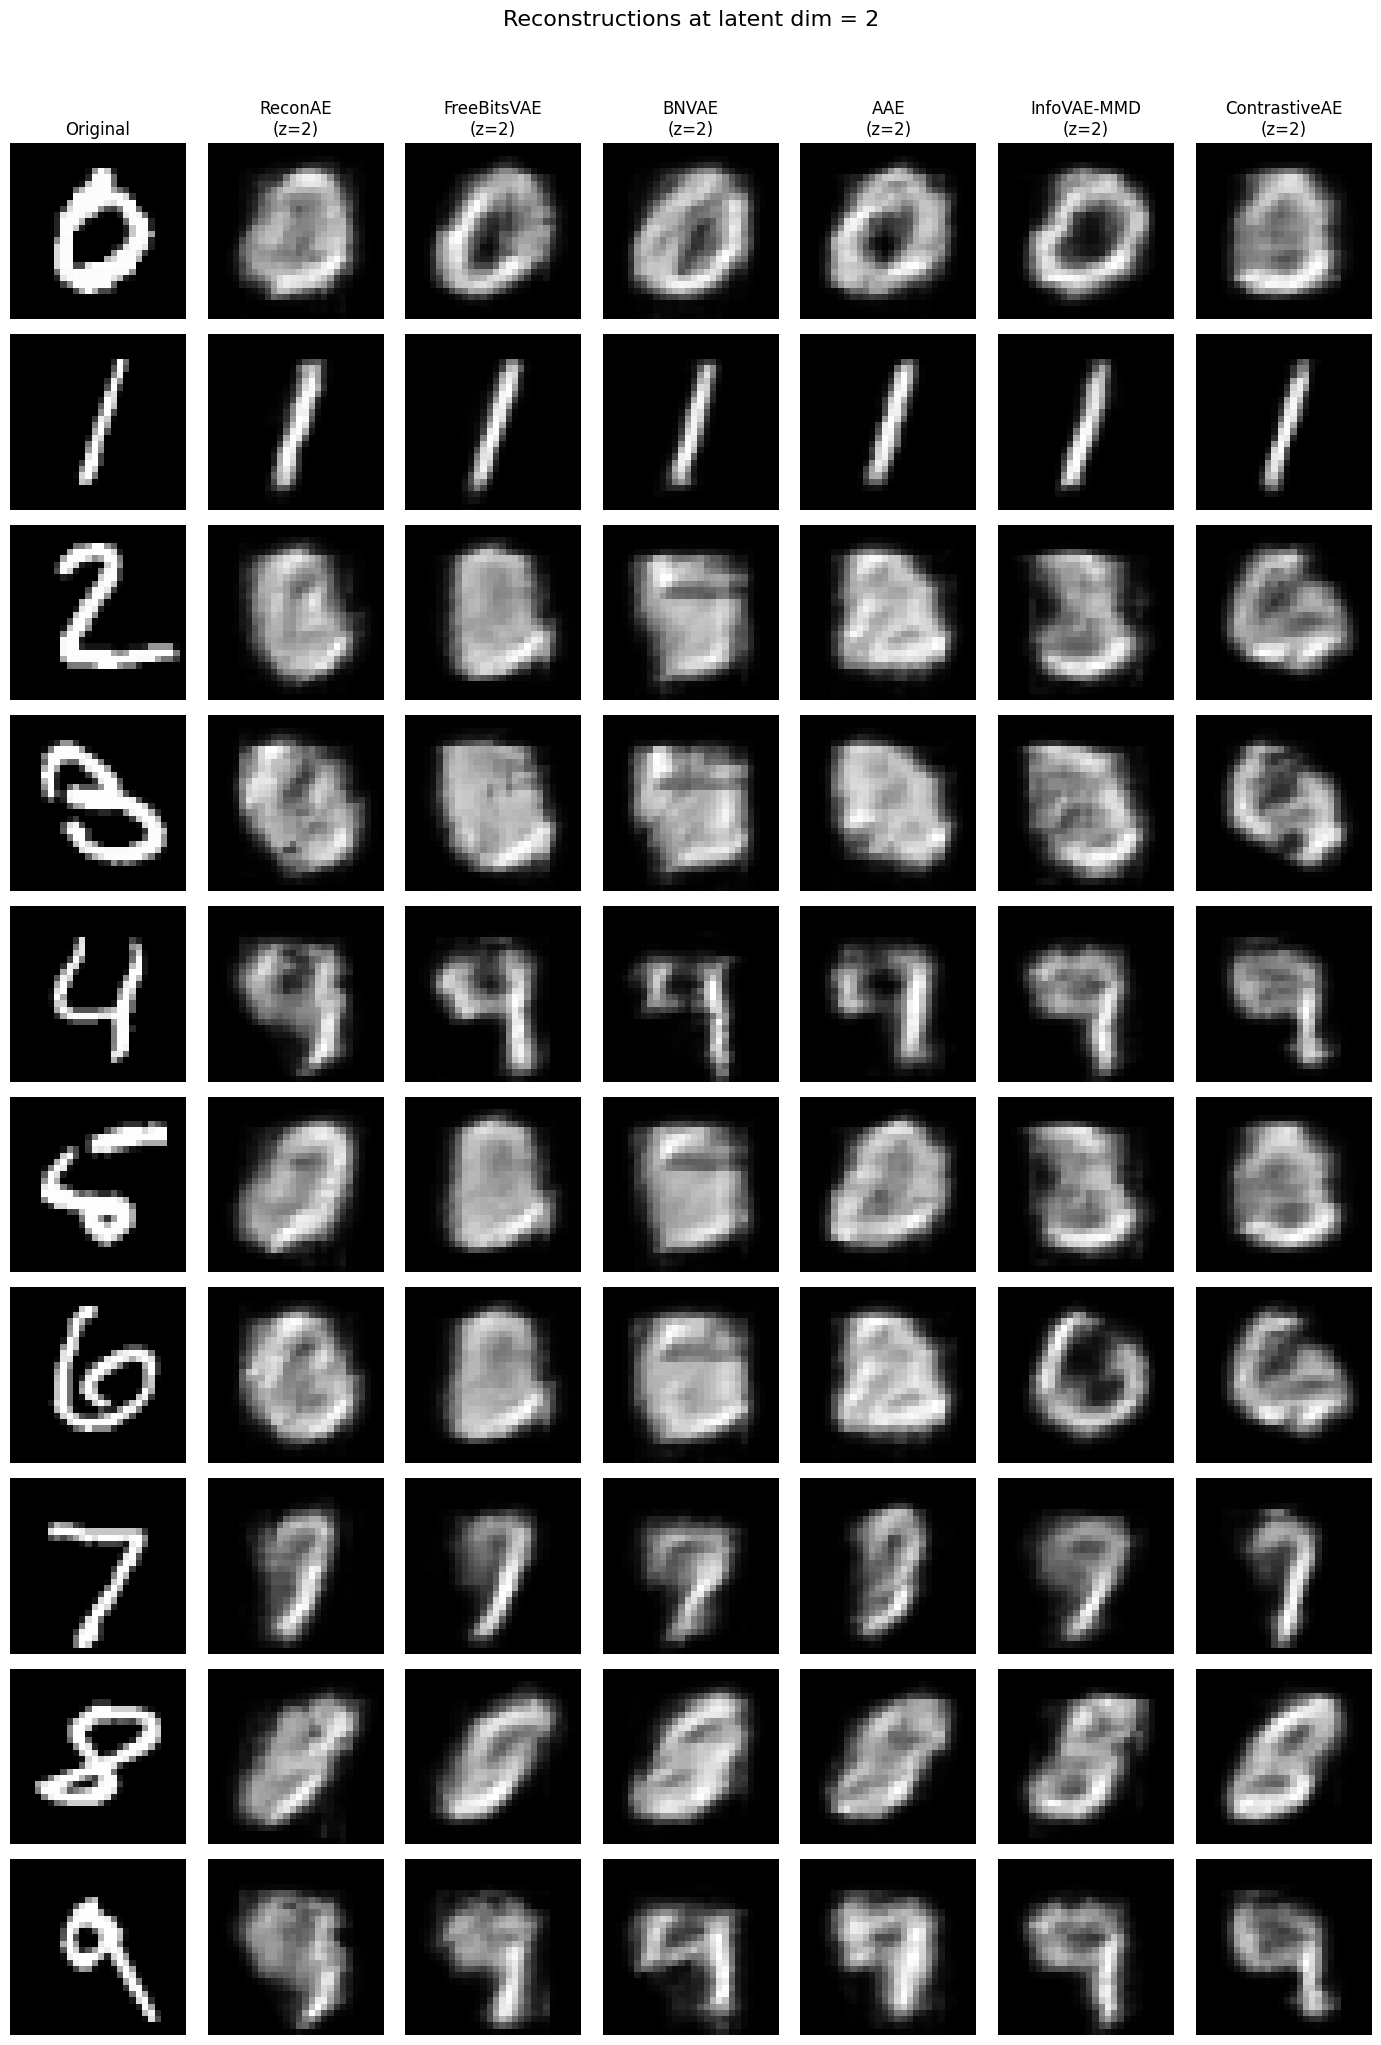

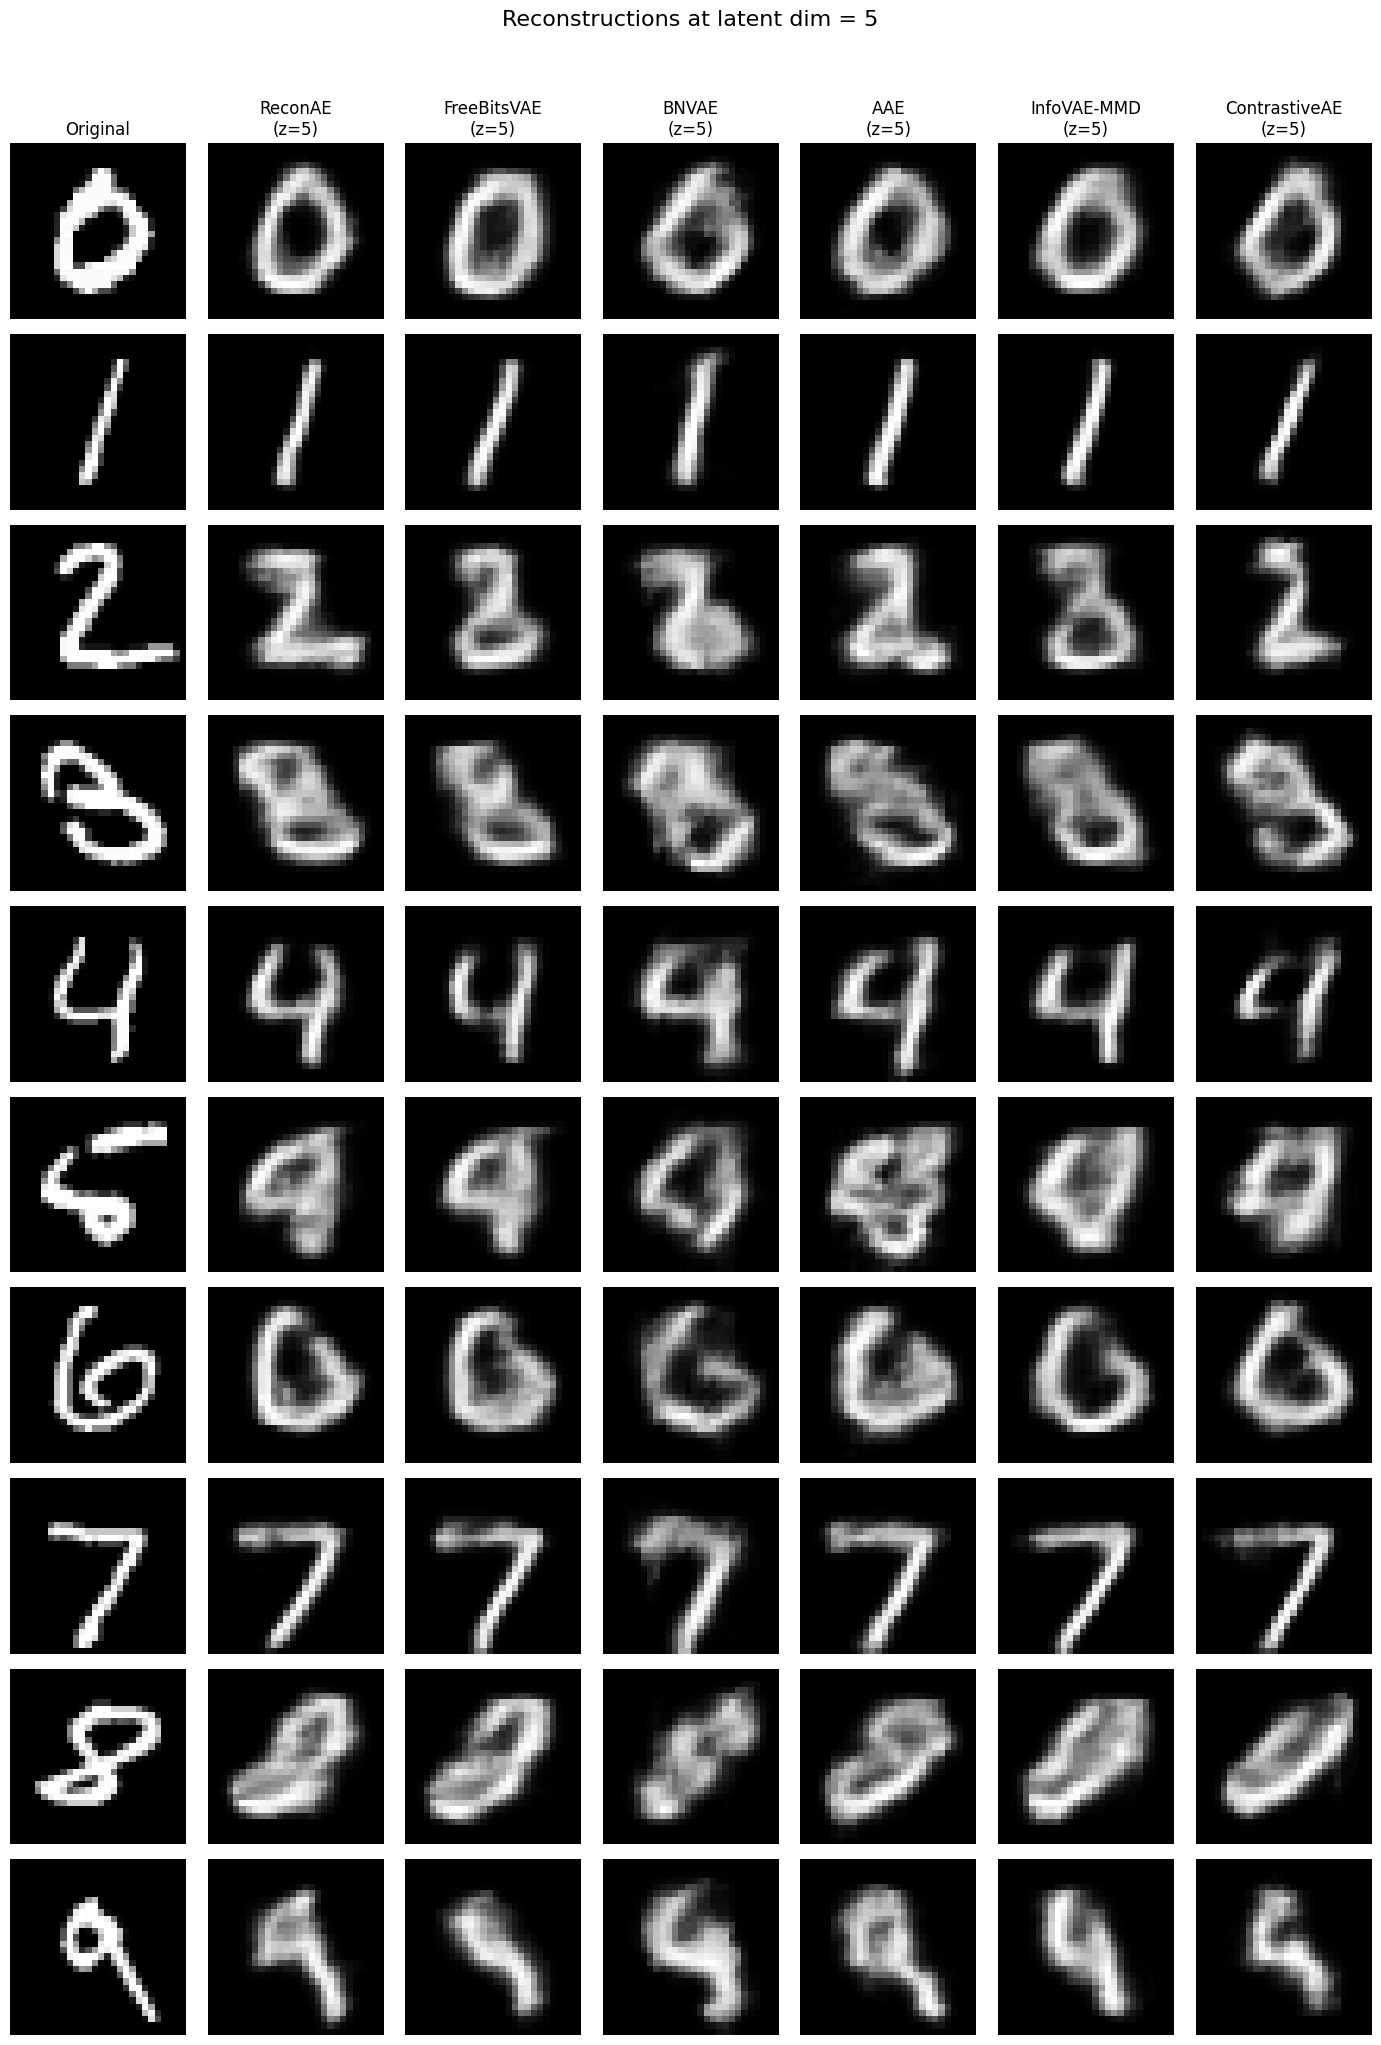

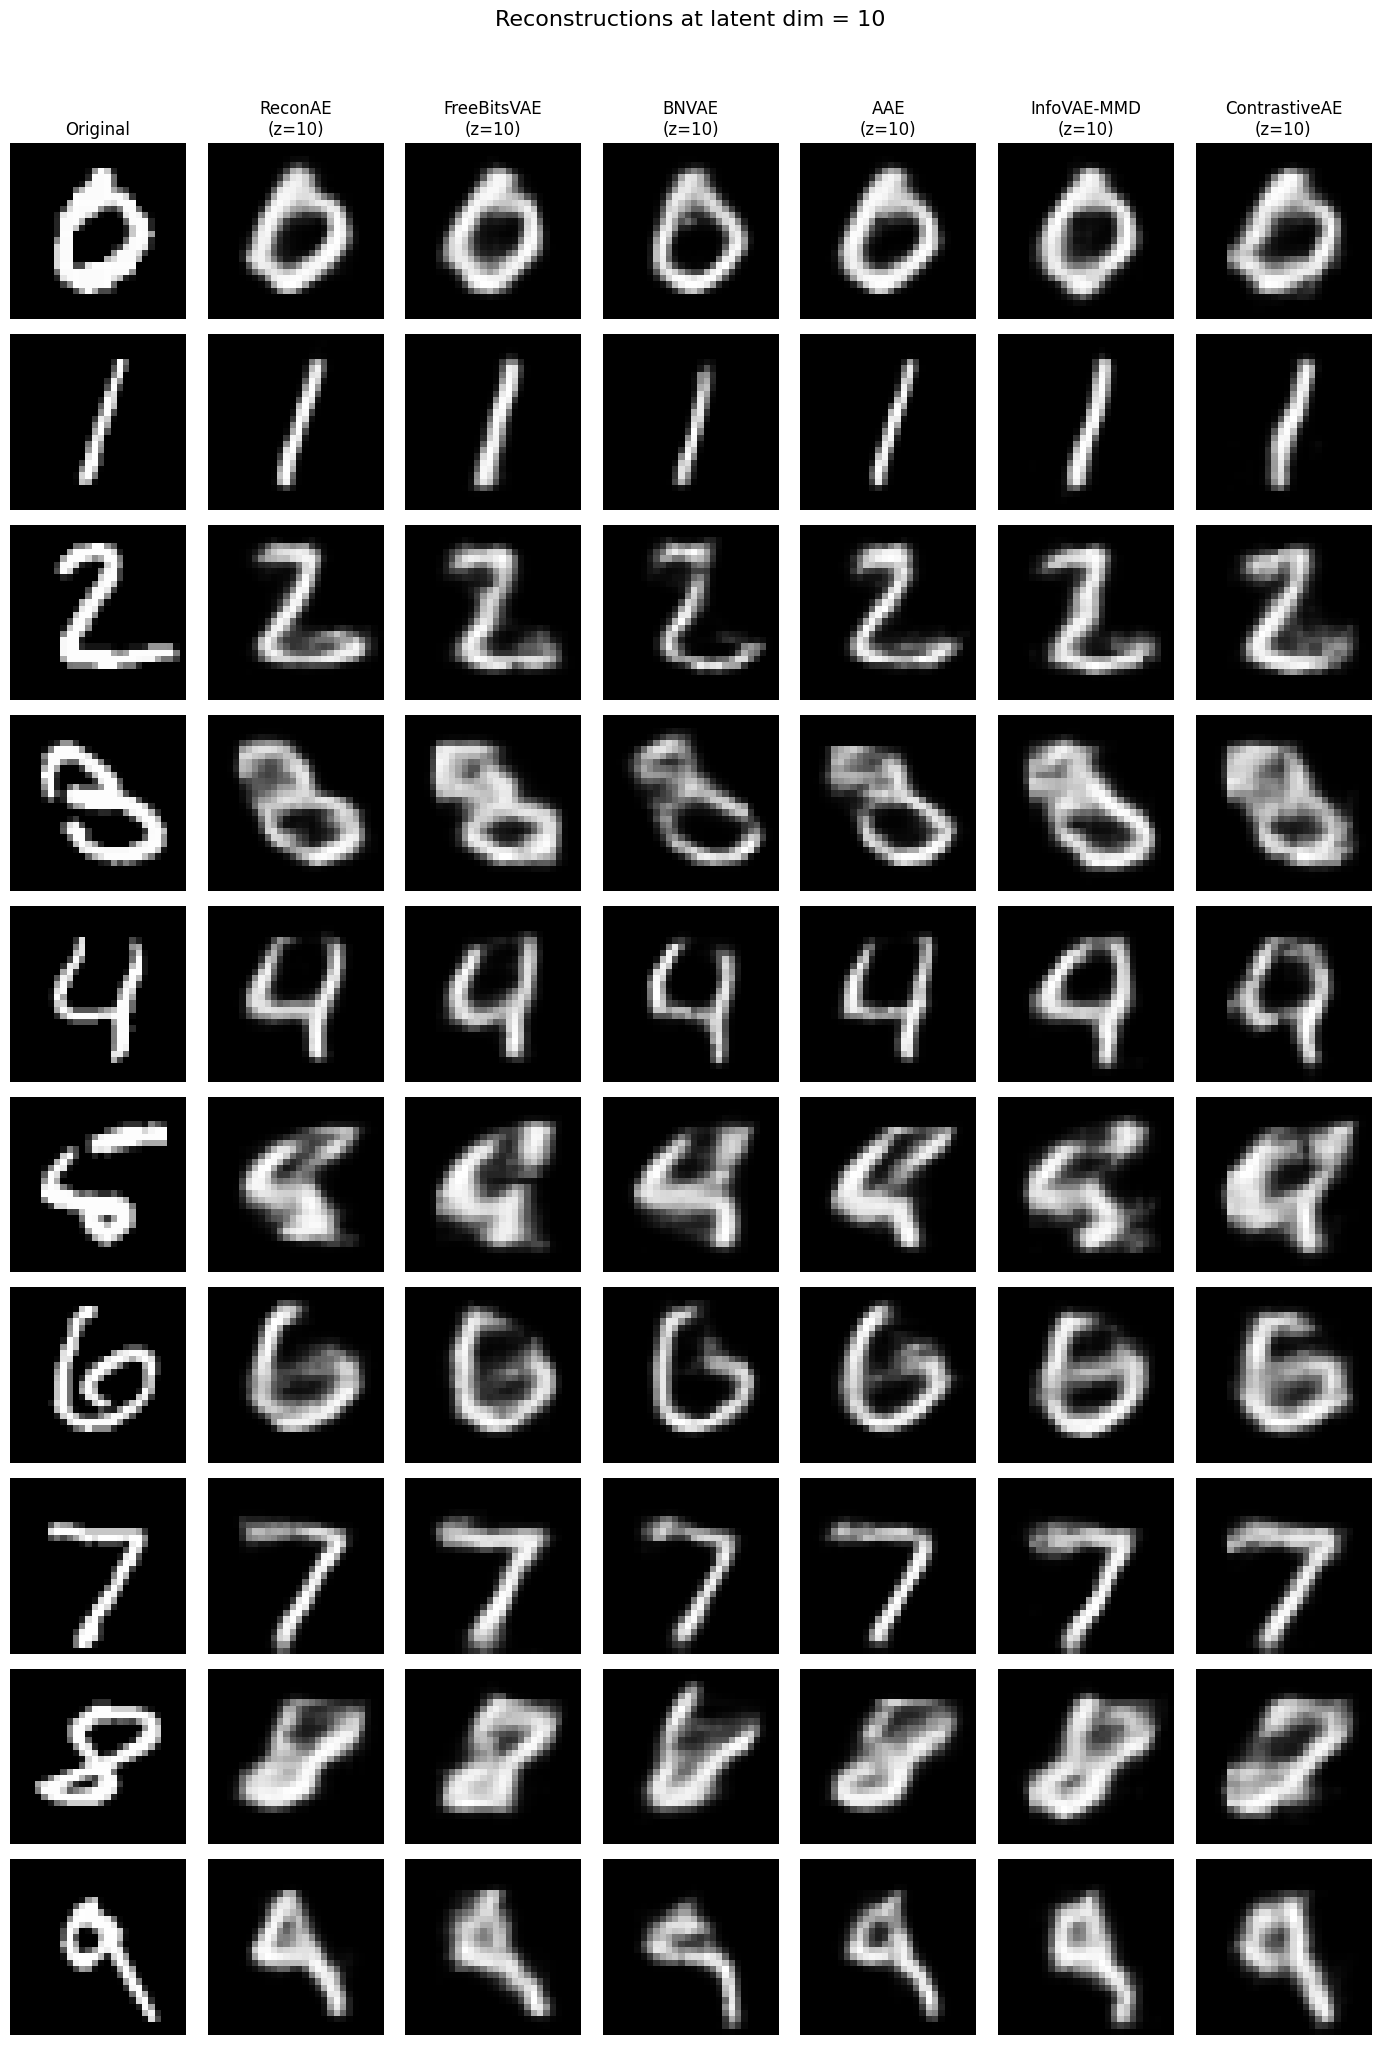

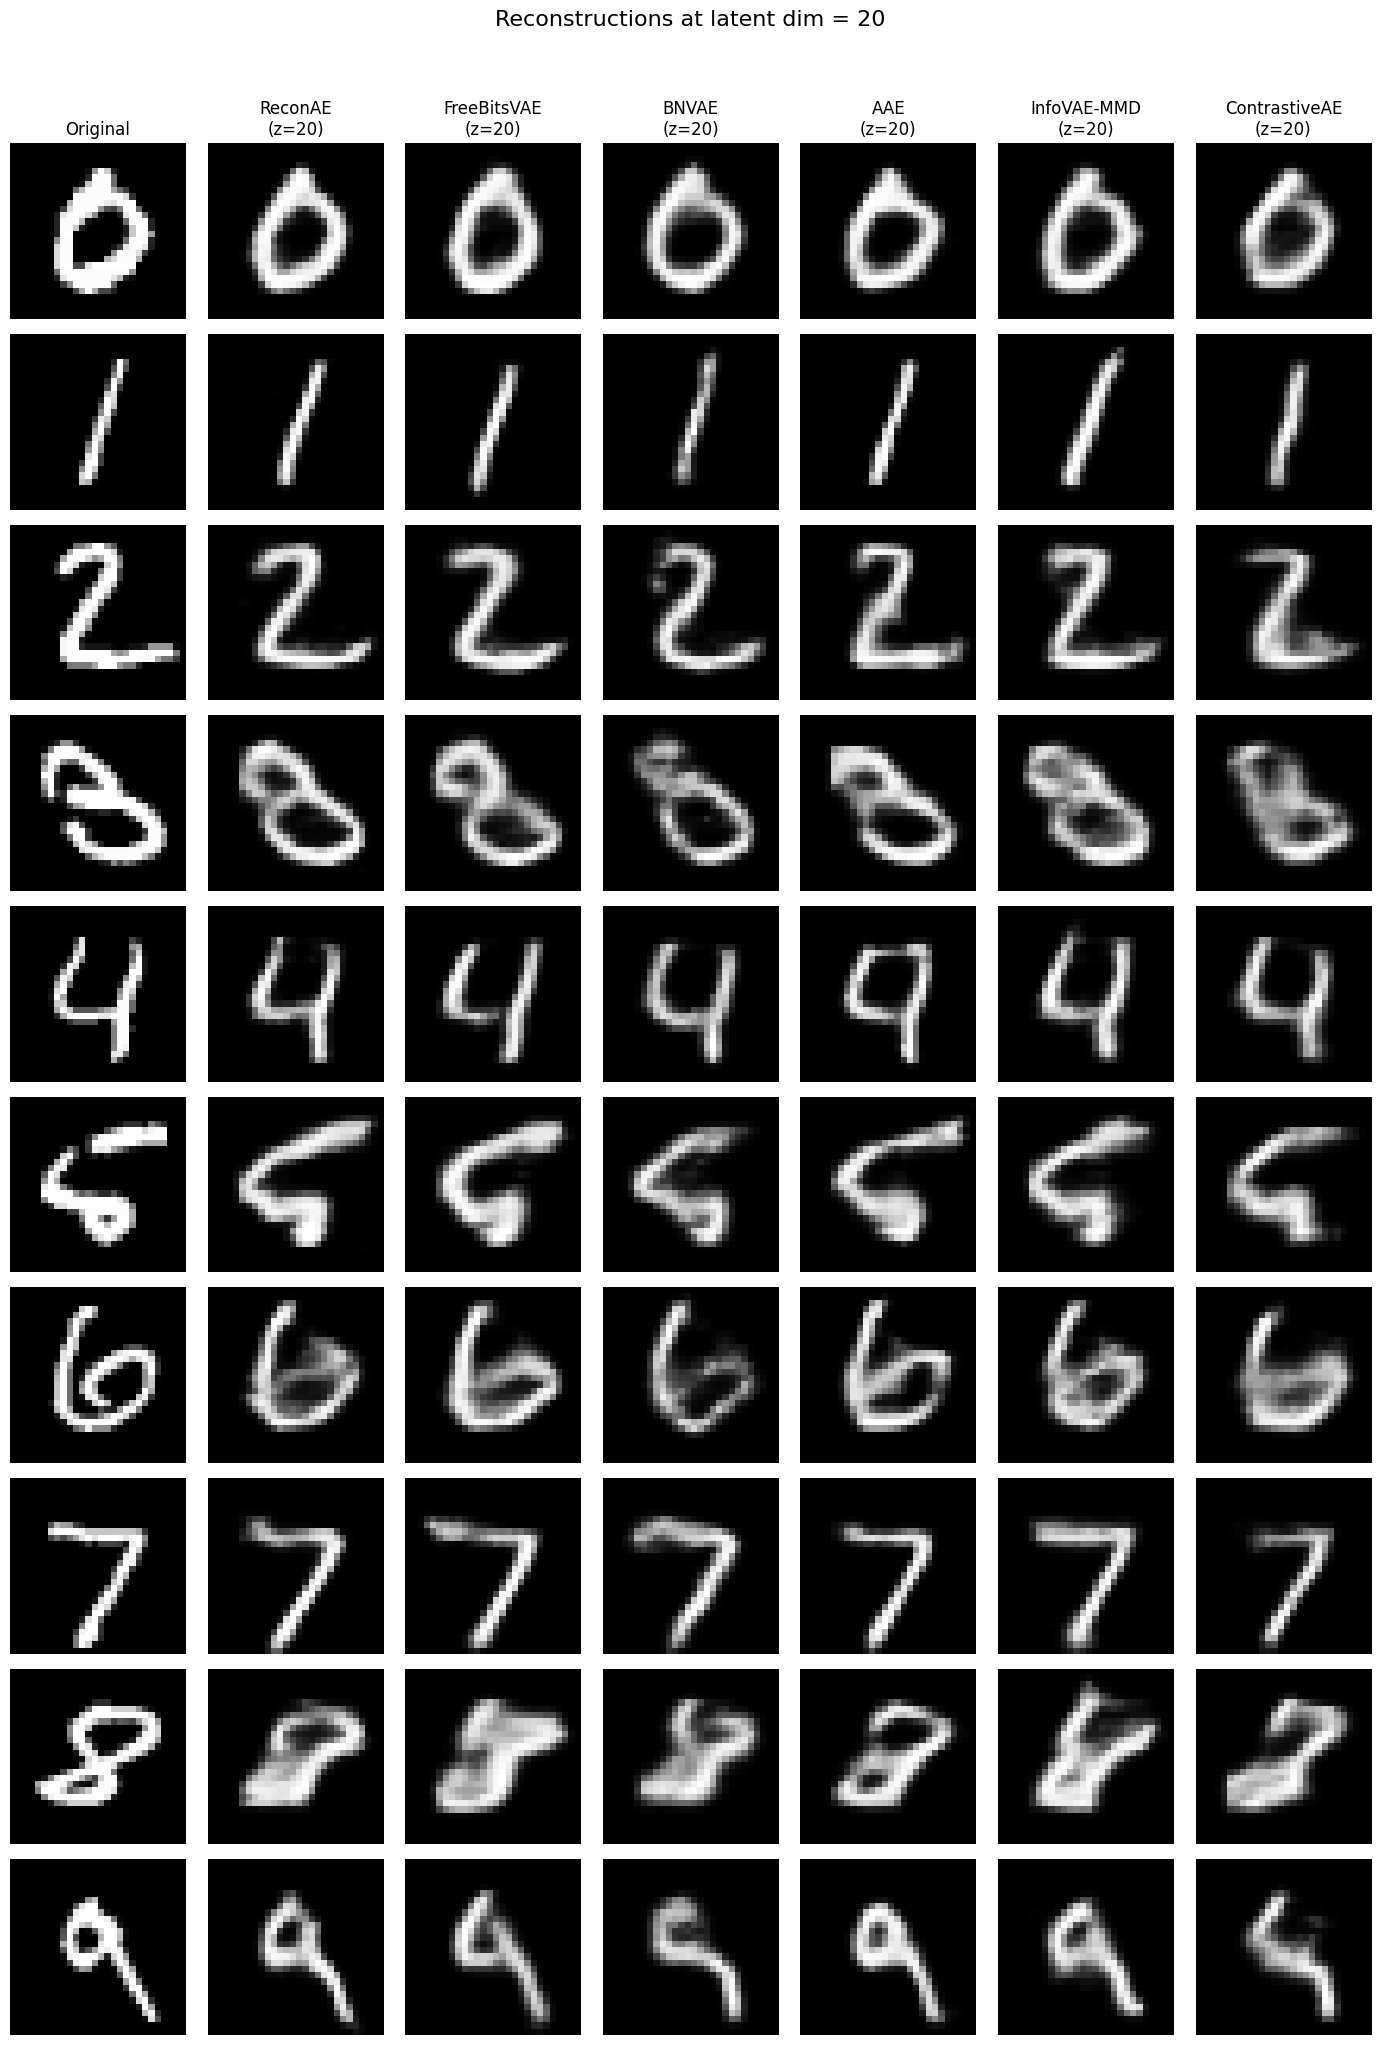

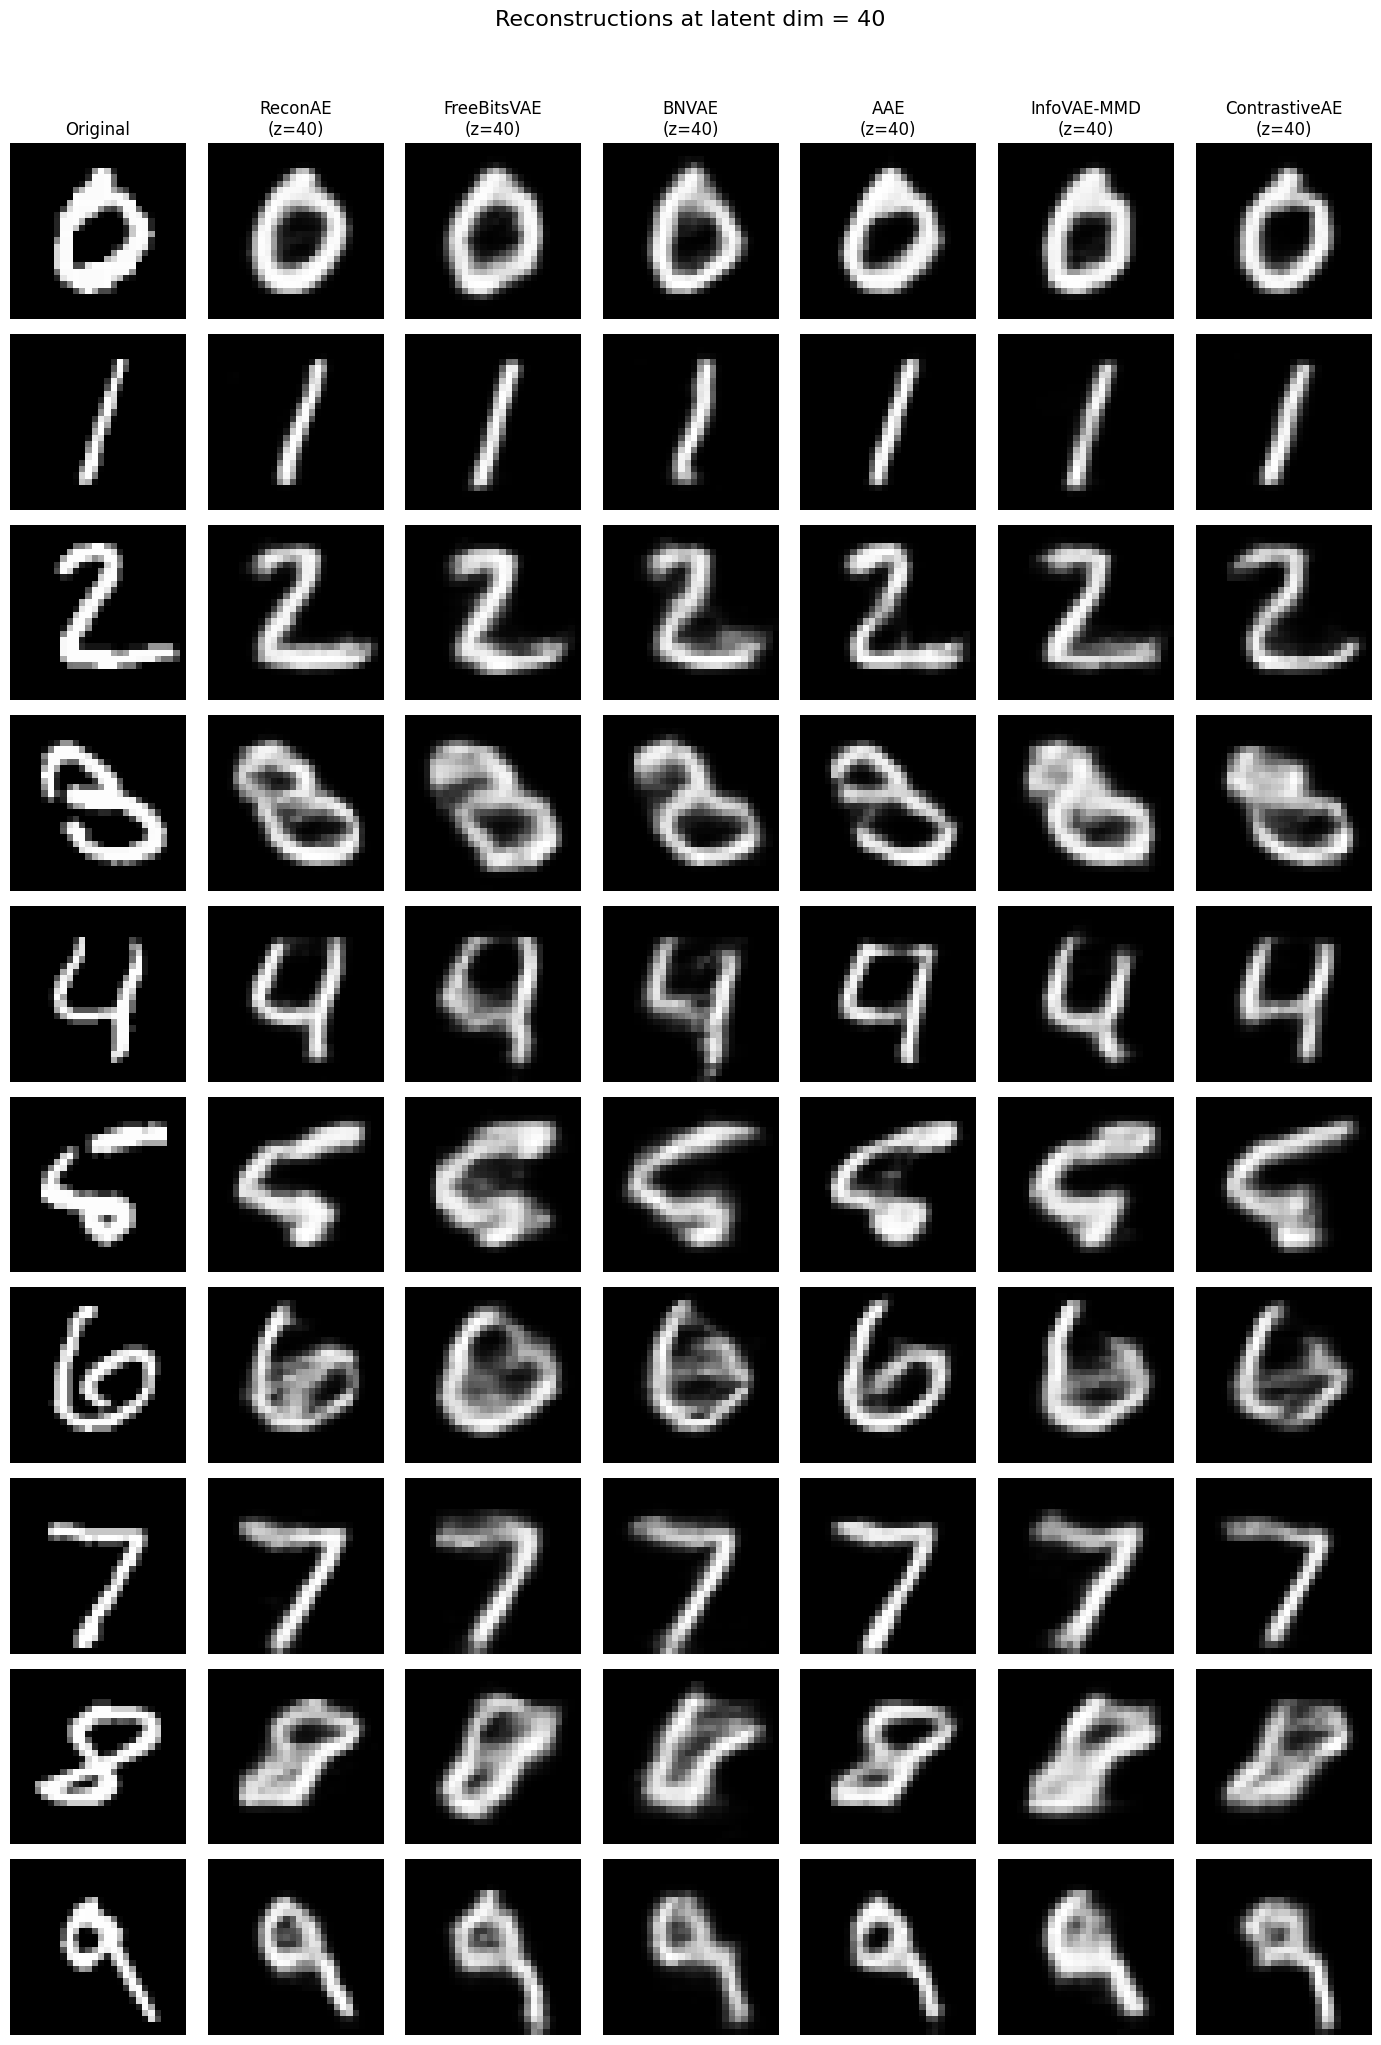

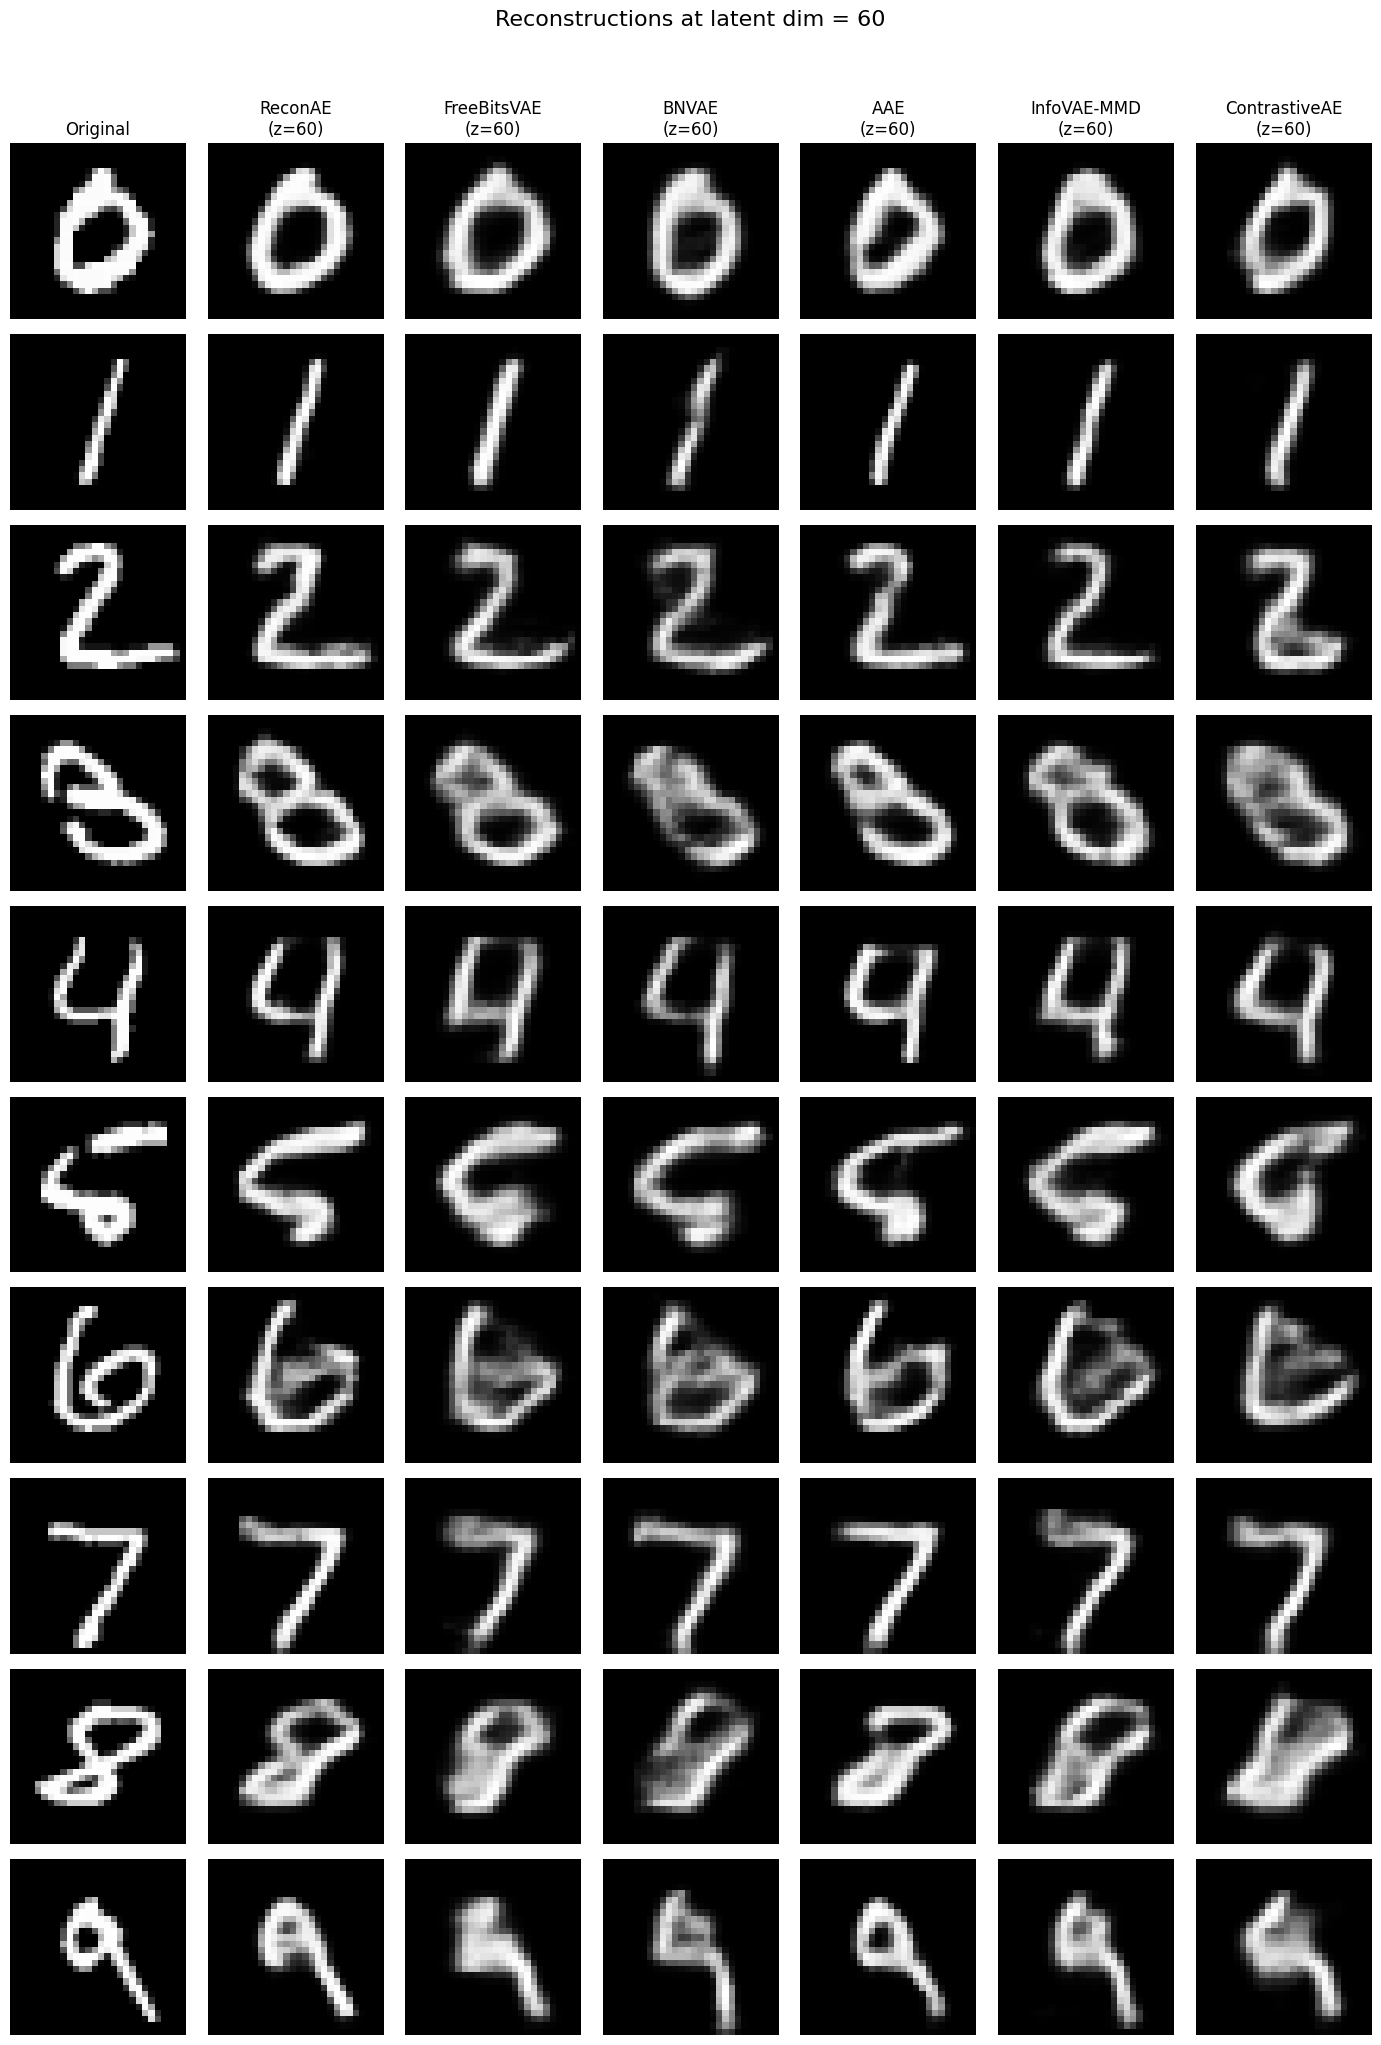

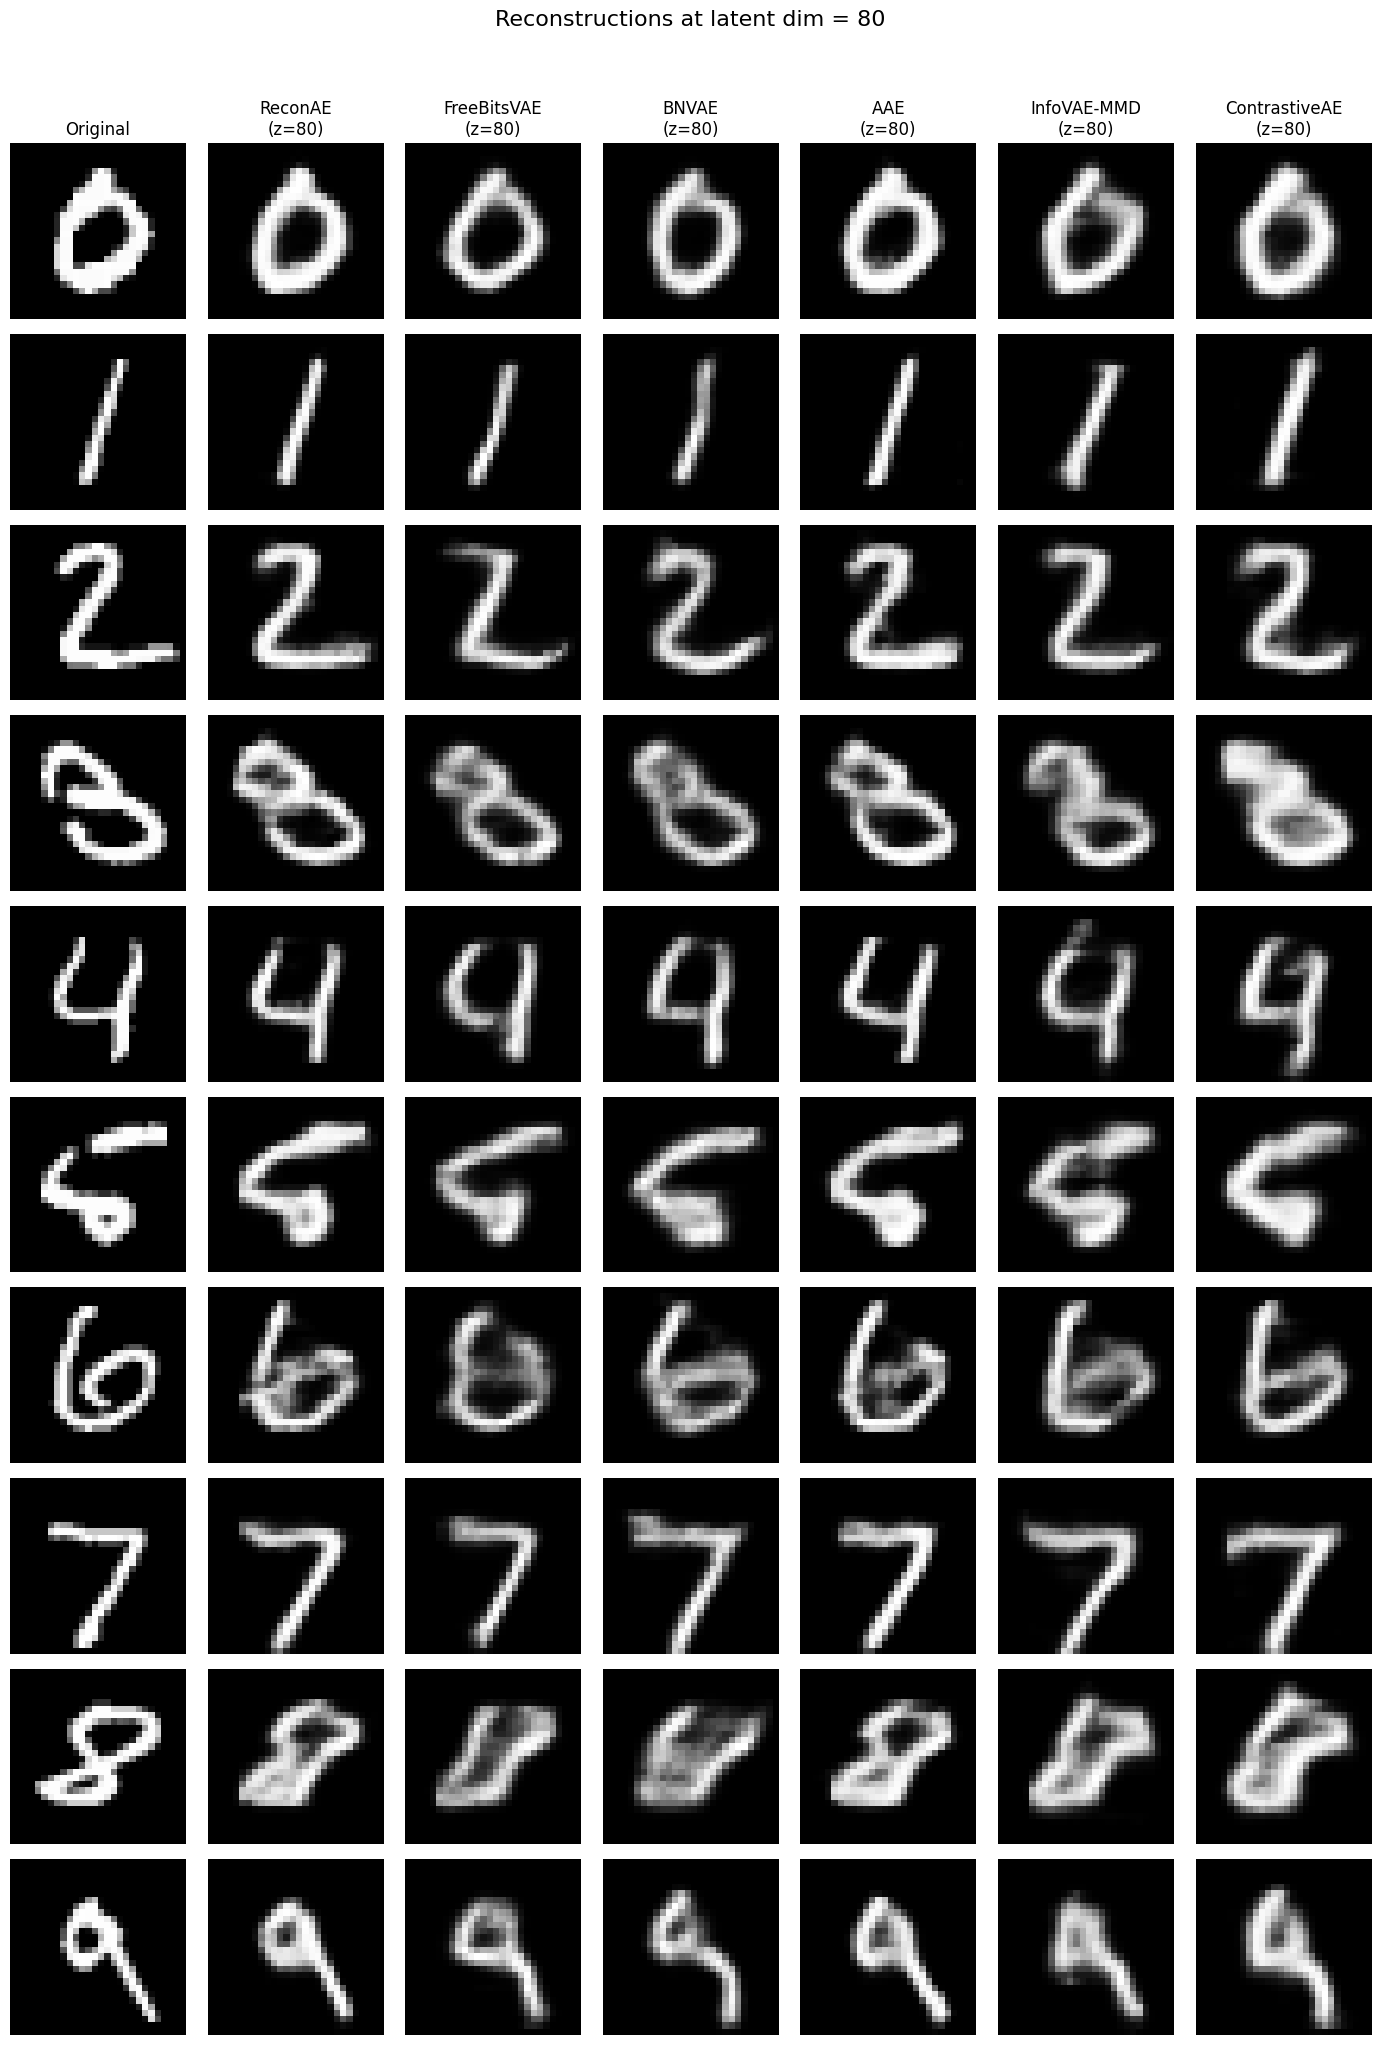

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------------------
# 0) Specify which models to skip
# ----------------------------------------------------------------------------
exclude_models = {"ELBOVAE", "BetaVAE"}

# ----------------------------------------------------------------------------
# Pre-compute one example per digit
# ----------------------------------------------------------------------------
digits_needed = set(range(10))
examples = {}
for x, y in test_loader:
    for img, label in zip(x, y):
        d = int(label.item())
        if d in digits_needed:
            examples[d] = img.unsqueeze(0).to(DEVICE)
            digits_needed.remove(d)
        if not digits_needed:
            break
    if not digits_needed:
        break
ordered_imgs = torch.cat([examples[d] for d in range(10)], dim=0)  # [10,C,H,W]

# ----------------------------------------------------------------------------
# 1) Filter out excluded models
# ----------------------------------------------------------------------------
model_items = [(n, m) for n, m in models.items() if n not in exclude_models]

# ----------------------------------------------------------------------------
# 2) Loop over all latent dims, plot & save
# ----------------------------------------------------------------------------
for latent_dim_plot in dims:
    n_cols = 1 + len(model_items)
    fig, axes = plt.subplots(
        10, n_cols,
        figsize=(2*n_cols, 2*10),
        sharex=True, sharey=True
    )
    if axes.ndim == 1:
        axes = axes[np.newaxis, :]

    # first column: originals
    for row in range(10):
        ax = axes[row, 0]
        ax.imshow(ordered_imgs[row].cpu().squeeze(), cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title("Original", fontsize=12)

    # other columns: reconstructions
    for col, (name, Cls) in enumerate(model_items, start=1):
        # instantiate, load weights, set eval
        m = Cls(z_dim=latent_dim_plot).to(DEVICE)
        m.load_state_dict(trained_states[(name, latent_dim_plot)])
        m.eval()
        with torch.no_grad():
            recon, *_ = m(ordered_imgs)

        for row in range(10):
            ax = axes[row, col]
            ax.imshow(recon[row].cpu().squeeze(), cmap='gray')
            ax.axis('off')
            if row == 0:
                ax.set_title(f"{name}\n(z={latent_dim_plot})",
                             fontsize=12)

    # big suptitle
    fig.suptitle(f"Reconstructions at latent dim = {latent_dim_plot}",
                 fontsize=16, y=1.02)
    plt.tight_layout()

    # save to disk
    plt.savefig(f"recon_z{latent_dim_plot}.png", bbox_inches="tight")
    plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------------------
# 0) Settings (assumes these exist in your namespace)
# ----------------------------------------------------------------------------
dims           = [2, 5, 10, 20, 40, 60, 80]
exclude_models = {"ELBOVAE", "BetaVAE"}
model_items    = [(n,cls) for n,cls in models.items() if n not in exclude_models]
n_models       = len(model_items)
n_cols         = 1 + n_models  # orig + each model
DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------------------------------------------------------
# 1) Pre-extract one example per digit from test_loader
# ----------------------------------------------------------------------------
# Build a dict: digit → single-image tensor [1,C,H,W]
examples = {}
digits_needed = set(range(10))
for x,y in test_loader:
    for img,label in zip(x,y):
        d = int(label.item())
        if d in digits_needed:
            examples[d] = img.unsqueeze(0).to(DEVICE)
            digits_needed.remove(d)
        if not digits_needed:
            break
    if not digits_needed:
        break

# ----------------------------------------------------------------------------
# 2) Loop over digits, plot & save
# ----------------------------------------------------------------------------
for digit in range(10):
    x0 = examples[digit]                             # [1,C,H,W]
    fig, axes = plt.subplots(
        nrows=len(dims), ncols=n_cols,
        figsize=(2*n_cols, 2*len(dims)),
        sharex=True, sharey=True
    )
    # ensure 2D axes
    if axes.ndim == 1:
        axes = axes[:, np.newaxis]

    # for each latent dim (row)
    for row, z_dim in enumerate(dims):
        # column 0: original
        ax = axes[row,0]
        ax.imshow(x0[0].cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title("Original", fontsize=12)

        # other columns: model reconstructions
        for col, (name,Cls) in enumerate(model_items, start=1):
            m = Cls(z_dim=z_dim).to(DEVICE)
            m.load_state_dict(trained_states[(name, z_dim)])
            m.eval()
            with torch.no_grad():
                recon = m(x0)[0]   # recon at index 0
            ax = axes[row,col]
            ax.imshow(recon[0].cpu().squeeze().numpy(), cmap='gray')
            ax.axis('off')
            if row == 0:
                ax.set_title(f"{name}\n(z={z_dim})", fontsize=12)

    # suptitle and save
    fig.suptitle(f"Reconstructions of digit {digit}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f"recon_digit{digit}.png", bbox_inches='tight')
    plt.close(fig)
